# Assignment 2 - Bank Marketing

Link to the data: https://archive.ics.uci.edu/dataset/222/bank+marketing

The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed. 

There are four datasets: 
1) bank.csv with 10% of the examples and 17 inputs, randomly selected from 3 (older version of this dataset with less inputs). 
2) bank-full.csv with all examples and 17 inputs, ordered by date (older version of this dataset with less inputs). 
3) bank-additional.csv with 10% of the examples (4119), randomly selected from 1), and 20 inputs.
4) bank-additional-full.csv with all examples (41188) and 20 inputs, ordered by date (from May 2008 to November 2010), very close to the data analyzed in [Moro et al., 2014]
The smallest datasets are provided to test more computationally demanding machine learning algorithms (e.g., SVM). 

The classification goal is to predict if the client will subscribe (yes/no) a term deposit (variable y) by this research question:

'Which features of client demographics, marketing strategies, and external economic indicators most strongly influence the likelihood of subscribing to a bank term deposit?'


In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
import seaborn as sns
import skfuzzy as fuzz
import dbscan
from sklearn.metrics import silhouette_score, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [2]:
df_bank = pd.read_csv('Ass2Data\\bank\\bank.csv', delimiter=';')
df_bank_full = pd.read_csv('Ass2Data\\bank\\bank-full.csv', delimiter=';')
df_bank_additional = pd.read_csv('Ass2Data\\bank-additional\\bank-additional\\bank-additional.csv', delimiter=';')
df_bank_additional_full = pd.read_csv('Ass2Data\\bank-additional\\bank-additional\\bank-additional-full.csv', delimiter=';')
df_bank.head()

age          job  marital  education default  balance housing loan  \
0   30   unemployed  married    primary      no     1787      no   no   
1   33     services  married  secondary      no     4789     yes  yes   
2   35   management   single   tertiary      no     1350     yes   no   
3   30   management  married   tertiary      no     1476     yes  yes   
4   59  blue-collar  married  secondary      no        0     yes   no   

    contact  day month  duration  campaign  pdays  previous poutcome   y  
0  cellular   19   oct        79         1     -1         0  unknown  no  
1  cellular   11   may       220         1    339         4  failure  no  
2  cellular   16   apr       185         1    330         1  failure  no  
3   unknown    3   jun       199         4     -1         0  unknown  no  
4   unknown    5   may       226         1     -1         0  unknown  no

Comparison between the 4 datasets
- df_bank: 4521 rows, 17 columns
- df_bank_full: 45211 rows, 17 columns

df_bank and df_bank_full have the same columns

- df_bank_additional: 4119 rows, 21 columns.
- df_bank_additional_full: 41188 rows, 21 columns.

Columns that are in the 'additional' datasets but not in the other 2: emp.var.rate, cons.price.idx, cons.conf.idx, euribor3m, nr.employed

Our research question, as written in the report, is: **Which client demographics (age, job, marital status, etc.) have the most influence on whether or not a client subscribes to a term deposit?**

Therefore, we will first filter out the columns that are not related to the client demographics. We will then perform exploratory data analysis to understand the data better. Since the 'additional' datasets do not contain demographic variables, we will take a subset of the regular bank_full dataset.

In [3]:
demographic_variables = ['age', 'job', 'marital', 'education', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'y']
df_demo = df_bank_additional_full[demographic_variables]

Demographic variables: \
`age` (numeric) \
`job` : type of job (categorical: "admin.","blue-collar","entrepreneur","housemaid","management","retired","self-employed","services","student","technician","unemployed","unknown") \
`marital` : marital status (categorical: "divorced","married","single","unknown"; note: "divorced" means divorced or widowed) \
`education` (categorical: "basic.4y","basic.6y","basic.9y","high.school","illiterate","professional.course","university.degree","unknown")

Social and economic context variables: \
`emp.var.rate`: employment variation rate - quarterly indicator (numeric) \
`cons.price.idx`: consumer price index - monthly indicator (numeric)     
`cons.conf.idx`: consumer confidence index - monthly indicator (numeric)
`euribor3m`: euribor 3 month rate - daily indicator (numeric) \
`nr.employed`: number of employees - quarterly indicator (numeric)   

# Advanced Exploratory Data Analysis 
Apply techniques from clustering and association rule mining domains.
- Data Cleaning: Outlier detection, summarizing dataset, descriptive stats, visualizations. Distribution of key variables
- AEDA: Scaling, normalization, one hot encoding, pair plots, correlation heatmaps
- Univariate and multivariate
- 2 clustering algorithms and evaluate them
- 2D plots, 3D plots
- association rules mining, evaluate them

## Data cleaning - iris
In this section,we ...
- determine the differences betweeen data sets
- handle null values,
- and analyze data distributions and outlers.
### Difference between dataframes

In [4]:
# Define difference in columns
columns_diff = set(df_bank_additional_full.columns) - set(df_bank_full.columns)
print(columns_diff)

{'nr.employed', 'cons.price.idx', 'emp.var.rate', 'cons.conf.idx', 'day_of_week', 'euribor3m'}


Conclusion:

`df_bank_additional_full` contains the day of the week, and has the social and economic context attributes.

These attributes represent:

`emp.var.rate`: employment variation rate - quarterly indicator (numeric) \
`cons.price.idx`: consumer price index - monthly indicator (numeric)     
`cons.conf.idx`: consumer confidence index - monthly indicator (numeric)
`euribor3m`: euribor 3 month rate - daily indicator (numeric) \
`nr.employed`: number of employees - quarterly indicator (numeric)

### Null values

Next, we will check for potential null values in our dataset. As mentioned in the data description: " _There are several missing values in some categorical attributes, all coded with the "unknown" label. These missing values can be treated as a possible class label or using deletion or imputation techniques._ "


In [5]:
#Check 'y' value of all rows with 'unknown' in them 
print(df_demo[df_demo['job'] == 'unknown']['y'].value_counts())
print(df_demo[df_demo['marital'] == 'unknown']['y'].value_counts())
print(df_demo[df_demo['education'] == 'unknown']['y'].value_counts())

no     293
yes     37
Name: y, dtype: int64
no     68
yes    12
Name: y, dtype: int64
no     1480
yes     251
Name: y, dtype: int64


In [6]:
#Check for values encoded with the 'unknown' label
df_demo.replace('unknown', np.nan, inplace=True);
df_demo.isnull().sum()

C:\Users\20201222\AppData\Local\Temp\ipykernel_22332\2746681656.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_demo.replace('unknown', np.nan, inplace=True);


age                  0
job                330
marital             80
education         1731
emp.var.rate         0
cons.price.idx       0
cons.conf.idx        0
euribor3m            0
nr.employed          0
y                    0
dtype: int64

Now, we are going to examine the data to see if the rows that contain missing values (NaNs) have a higher tendency to have "yes" or "no" in a specific column.

In [7]:
# Count the number of NaN values in each column for y = yes and y = no
nan_counts = df_demo[df_demo[['job', 'marital', 'education']].isna().any(axis=1)].groupby('y').agg(
    job_nan=('job', lambda x: x.isna().sum()),
    marital_nan=('marital', lambda x: x.isna().sum()),
    education_nan=('education', lambda x: x.isna().sum()),
).reset_index()

# Add the total counts of y values
y_counts = df_demo['y'].value_counts().reset_index()
y_counts.columns = ['y', 'y_count']

# Merge the NaN counts with the total counts
nan_counts = nan_counts.merge(y_counts, on='y')

# Display the table
nan_counts

y  job_nan  marital_nan  education_nan  y_count
0   no      293           68           1480    36548
1  yes       37           12            251     4640

The missing values have a higher tendency to have a "no" value for y. However, the "yes/no" ratio is not that different from the original ratio of the y values.

The total amount rows with 'unknown' values for either job or education come down to about 5% of the total data. Since this is a small percentage, and the "yes/no" ratio is not dissimilar from the original y value counts, we have decided to drop these rows.

In [8]:
#Drop rows with missing values
pre = df_demo.shape[0]
df_demo.dropna(inplace=True);
post = df_demo.shape[0]

print('Deleted rows: ', pre - post)
df_demo.isnull().sum()

Deleted rows:  1997


C:\Users\20201222\AppData\Local\Temp\ipykernel_22332\1969627028.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_demo.dropna(inplace=True);


age               0
job               0
marital           0
education         0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

### Define numerical and categorical columns

In [9]:
# Extract numerical column names
numerical_columns = df_demo.select_dtypes(include=['number']).columns.tolist()

# Extract categorical column names
categorical_columns = df_demo.select_dtypes(include=['object']).columns.tolist()

print("Numerical columns:", numerical_columns)
print("Categorical columns:", categorical_columns)

categorical_columns.remove('y') #Remove the target variable

Numerical columns: ['age', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
Categorical columns: ['job', 'marital', 'education', 'y']


### Data distribution and outliers

In [10]:
#show summary statistics for (numerical) data
df_demo[numerical_columns].describe(include='all')

age  emp.var.rate  cons.price.idx  cons.conf.idx  \
count  39191.000000  39191.000000     39191.00000   39191.000000   
mean      39.858003      0.083238        93.57172     -40.537146   
std       10.288300      1.566502         0.57705       4.621895   
min       17.000000     -3.400000        92.20100     -50.800000   
25%       32.000000     -1.800000        93.07500     -42.700000   
50%       38.000000      1.100000        93.44400     -41.800000   
75%       47.000000      1.400000        93.99400     -36.400000   
max       98.000000      1.400000        94.76700     -26.900000   

          euribor3m   nr.employed  
count  39191.000000  39191.000000  
mean       3.623633   5167.404340  
std        1.730493     71.787741  
min        0.634000   4963.600000  
25%        1.344000   5099.100000  
50%        4.857000   5191.000000  
75%        4.961000   5228.100000  
max        5.045000   5228.100000

*Conclusions summary statistics*

- The average age is 39.858 years old. 
- The variation rate of employment is very low with an average of 0.083238. 
- The index of the consumption price is over 90, indicating that the inflation is stable. 
- The confidence of consumption is negative; the average value is -40.537146. This means people are not optimistic about the economy. 
- Euribor3m is 3.623633; it means the interest rate is not very high. 
- The number of employees is around 5167.404340. 
 
While the data is indicative of a relatively stable economic state of the country, on the other hand, the consumption confidence index is negative, which means the consumers do not feel optimistic about the future. This may become indicative of the fact that the economy is not growing as fast as it should.

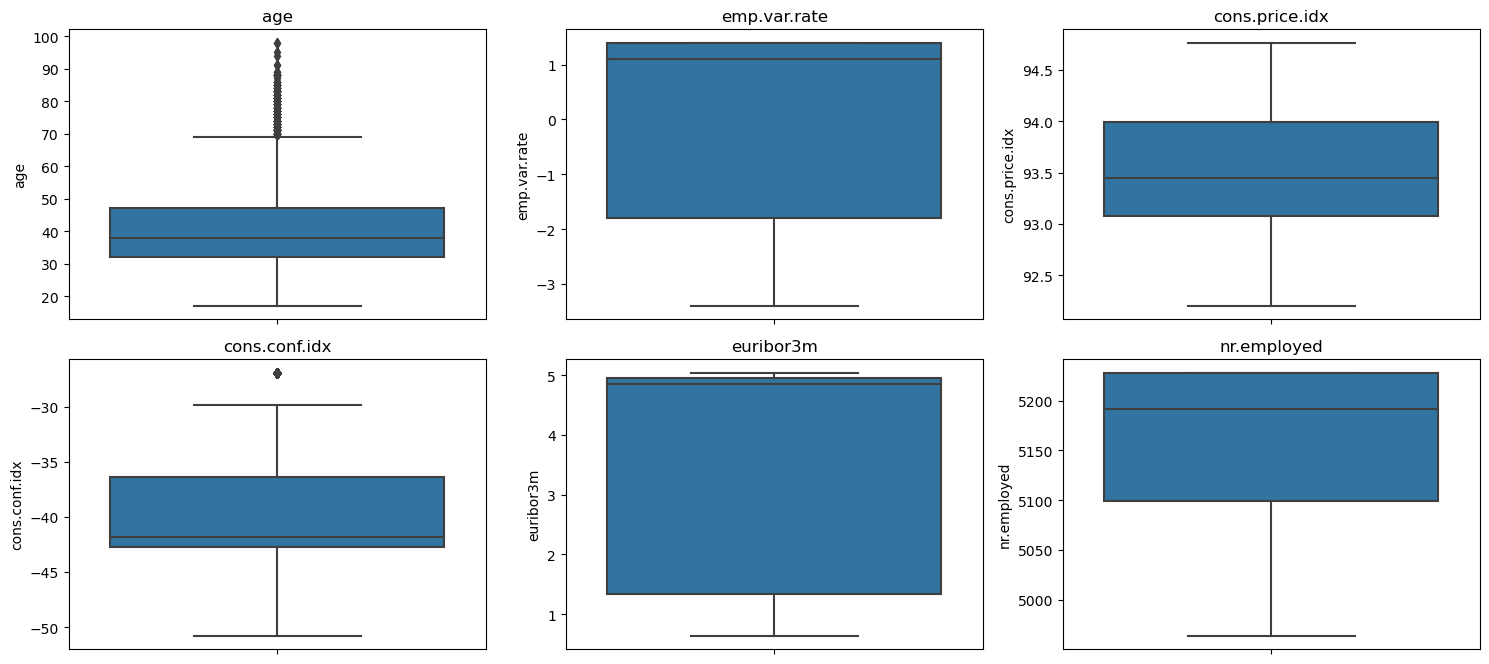

In [11]:
# create a figure with barplot subplots
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numerical_columns, 1):
    plt.subplot(len(numerical_columns)//3 + 1, 3, i)
    sns.boxplot(y=df_demo[feature], showfliers=True)
    plt.title(feature)
plt.tight_layout()
plt.show()


It appears only `age` has some outliers. To even better undertsan dthe data, we make some histograms.

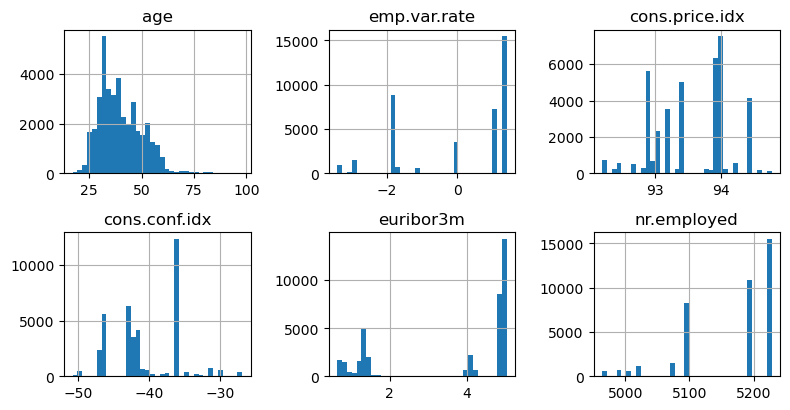

In [12]:
# create a figure with histogram subplots
plt.figure(figsize=(8, 6))
for i, feature in enumerate(numerical_columns, 1):
    plt.subplot(len(numerical_columns)//3 + 1, 3, i)
    df_demo[feature].hist(bins=35)
    plt.title(feature)
plt.tight_layout()
plt.show()


*[TODO] CONCLUSIE SCHRIJVEN OVER HISTOGRAMS*

## Feature engineering - iris

In this section, we
- explain why we did not normalize data,
- label encode categorical variables,
- analyze possible correlations between variables,
- and make sampling considerations.

### Normalize numerical columns
Since the numerical clumns are not highly skewed, we decieded to not normalize them.

In [13]:
#-------------CODE HIER ALLEEN RELEVANT ALS WE MEER DAN AGE GEBRUIKEN-----------

# from sklearn.preprocessing import MinMaxScaler
# import sklearn.preprocessing

# # Initialize the MinMaxScaler
# scaler = MinMaxScaler()

# # Columns to normalize
# columns_to_normalize = [col for col in numerical_columns if col not in ['age', 'day']]

# # Apply the scaler to the selected columns and rename them
# normalized_columns = [f"{col}_norm" for col in columns_to_normalize]
# df_demo[normalized_columns] = sklearn.preprocessing.normalize(df_demo[columns_to_normalize])

# print(df_demo[normalized_columns].head())

In [14]:
# # Outliers for normalized columns
# fig, axes = plt.subplots(3, 3, figsize=(15, 10))

# # Plot each normalized column in a separate subplot
# for i, column in enumerate(normalized_columns, 1):
#     plt.subplot(len(normalized_columns)//3 + 1, 3, i)
#     sns.boxplot(y=df_bank[column], showfliers=True)
#     plt.title(column)
# plt.tight_layout()
# plt.show()


In [15]:
# plt.figure(figsize=(15, 10))
# for i, feature in enumerate(normalized_columns, 1):
#     plt.subplot(len(normalized_columns)//3 + 1, 3, i)
#     df_bank[feature].hist(bins=35)
#     plt.title(feature)
# plt.tight_layout()
# plt.show()


### Label encoding of categorical features
The categorical variables all contains string values. These are hard to process for clustering or modeling algorithms. Therefore, they should be encoded.

Considering one-hot encoding would result in a large amount of extra columns, we decided to use label encoding.

In [16]:
from sklearn.preprocessing import LabelEncoder

df_demo_encoded = df_demo #Copy dataset for encoding

# Apply label encoding to categorical columns
label_mappings = {}

for column in categorical_columns:
    le = LabelEncoder()
    ids = le.fit_transform(df_demo_encoded[column])
    df_demo_encoded[column] = ids
    mapping = dict(zip(le.classes_, range(len(le.classes_))))
    label_mappings.update(mapping)

#Encode the target variable
df_demo_encoded['y'] = df_demo_encoded['y'].map({'yes': 1, 'no': 0})
print(label_mappings)

{'admin.': 0, 'blue-collar': 1, 'entrepreneur': 2, 'housemaid': 3, 'management': 4, 'retired': 5, 'self-employed': 6, 'services': 7, 'student': 8, 'technician': 9, 'unemployed': 10, 'divorced': 0, 'married': 1, 'single': 2, 'basic.4y': 0, 'basic.6y': 1, 'basic.9y': 2, 'high.school': 3, 'illiterate': 4, 'professional.course': 5, 'university.degree': 6}


C:\Users\20201222\AppData\Local\Temp\ipykernel_22332\3881851478.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_demo_encoded[column] = ids
C:\Users\20201222\AppData\Local\Temp\ipykernel_22332\3881851478.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_demo_encoded[column] = ids
C:\Users\20201222\AppData\Local\Temp\ipykernel_22332\3881851478.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

### Correlation matrices

Firstly, we make a correlation matrix that includes all variables.

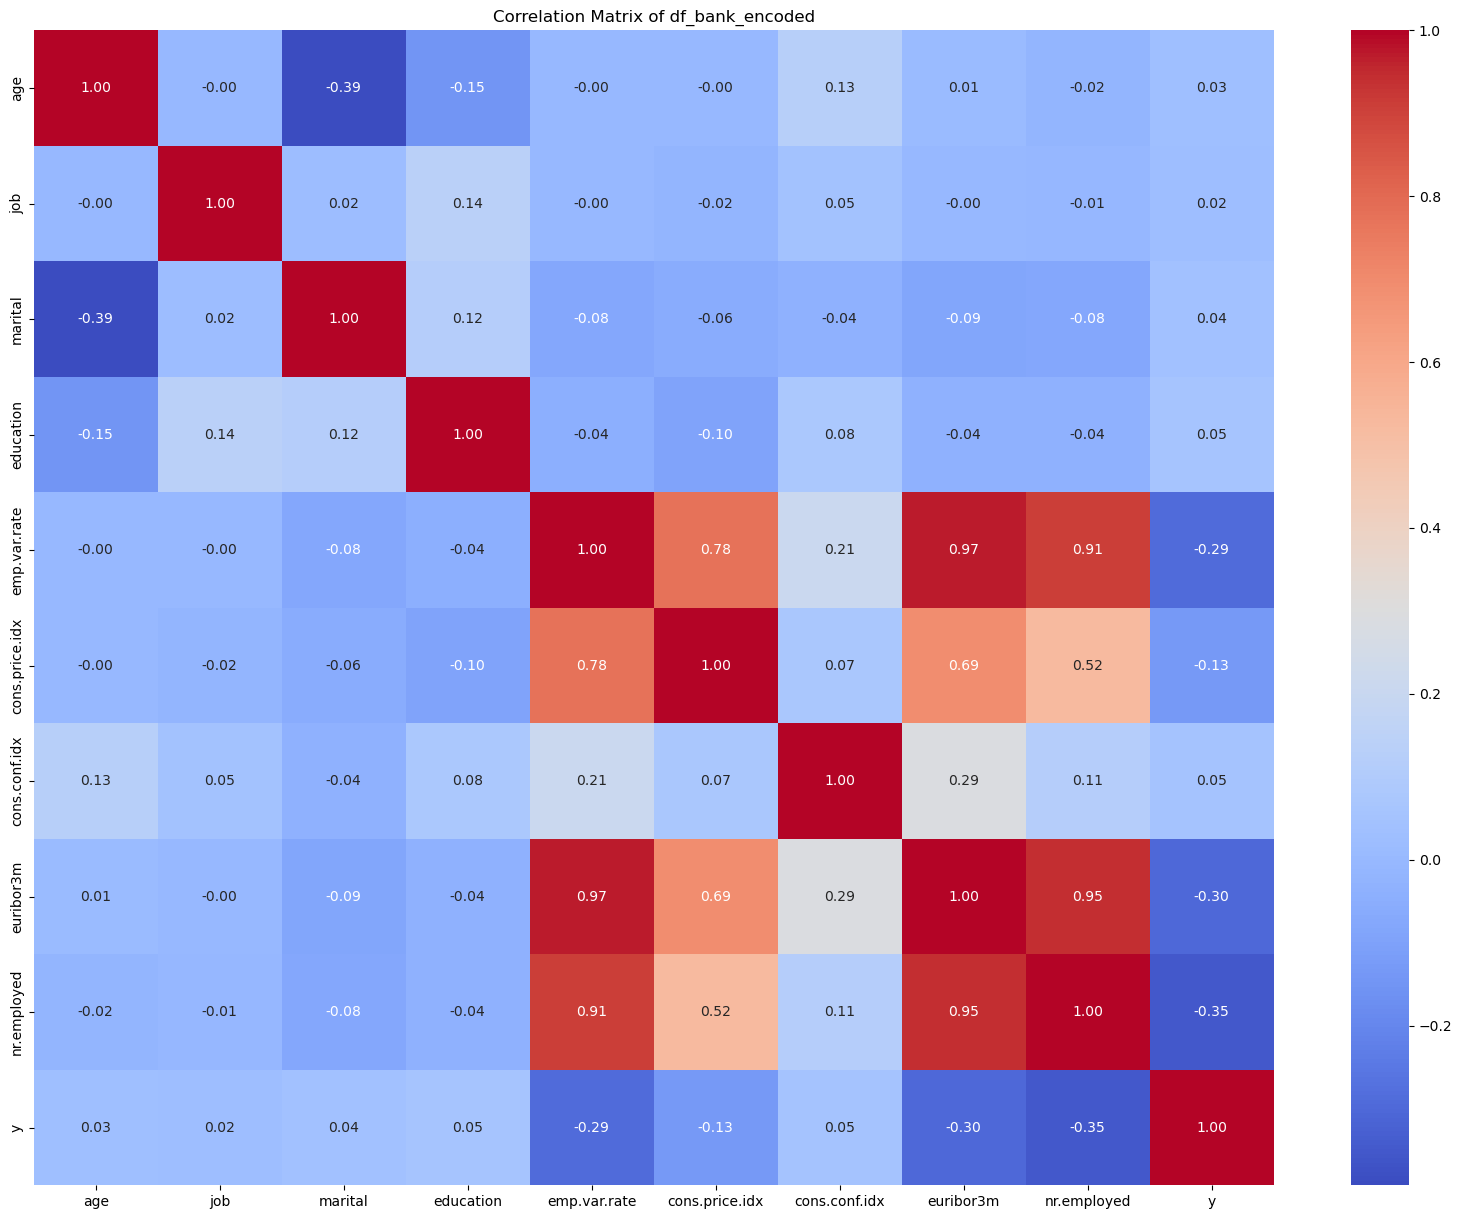

In [17]:
# Calculate the correlation matrix
correlation_matrix = df_demo_encoded.corr()

# Plot the heatmap
plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix of df_bank_encoded')
plt.show()

- Employment-Related Variables: There's a strong positive correlation between `emp.var.rate`, `cons.price.idx`, `euribor3m`, and `nr.employed`. This suggests that changes in employment rates significantly impact consumer prices, interest rates, and the number of employed individuals. A decrease in employment rates leads to a decrease in consumer prices, an increase in interest rates, and a reduction in the number of people employed. <br>
  Especially the correlation between `emp.var.rate` and `nr.employed` is logical because they both explain employement.
- Demographical variables: There is a weak to no correlation between the categorical variables `job`, `marital`, and `education` and any other variable. This would indicate they are independent.


**NOTE:** The variables `job`, `marital`, and `education` seem to have a weak to low crrelation. However, they are label encoded, thus the correlation might not capture the true relationships.

We are interested in which variables correlate with the target variable the most, therefore, we select all correlations with `y` and sort the absolute values from high to low. We sort on absolute values because of the fact a negative effect is also an effect we would like to know.

In [18]:
# Calculate the correlation matrix for the target variable 'y' and other features
y_corr = df_demo_encoded.corr()[['y']]
print(y_corr)

                       y
age             0.030557
job             0.020840
marital         0.041972
education       0.054412
emp.var.rate   -0.293264
cons.price.idx -0.133833
cons.conf.idx   0.051365
euribor3m      -0.302094
nr.employed    -0.349526
y               1.000000


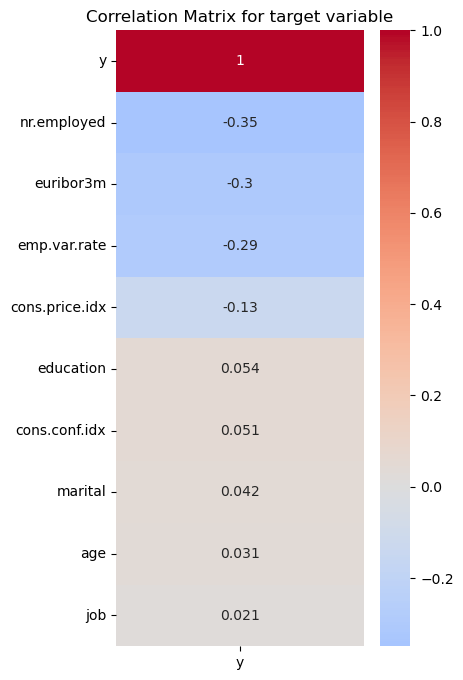

In [19]:
# Filter the correlation matrix for y_no and y_yes where the absolute value of correlation is higher than 0.1
#filtered_corr_matrix = y_corr[(y_corr['y_yes'].abs() > 0.1)]
filtered_corr_matrix = y_corr

#Sort the values by the absolute value of correlation for visualization purposes
filtered_corr_matrix = filtered_corr_matrix.reindex(filtered_corr_matrix['y'].abs().sort_values(ascending=False).index)

# Plot the heatmap for the filtered correlation matrix
plt.figure(figsize=(4, 8))
sns.heatmap(filtered_corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix for target variable')
plt.show()

- *Strong **positive** correlation* between `y` and `emp.var.rate`, `cons.price.idx`, `euribor3m`, and `nr.employed`. This strong correlation between them might indicate they are good predictors.
- *Moderate **positive** correlation* between `y` and `cons.conf.idx`. This suggests  this variable also has some predictive power, though it's not as strong as the other variables mentioned above.
- *Weak **positive** correlation* between `y` and `education`. This implies there's a slightly positive association between education and the target variable.
- *Low to no correlation* between `y` and `age`, `job`, and `marital`. This suggests these variables might not be significant predictors for the target variable.

**NOTE:** Again, the variables `education`, `marital` and `job` seem to have a weak to low crrelation. However, they are label encoded, thus the correlation might not capture the true relationships.

In [20]:
# Create pair plots
# sns.pairplot(df_demo_encoded)
# plt.show()

Ik denk dat deze pair plot overbodig is, geeft ons vgm niet veel extra informatie
- Onno

### Sampling considerations
There are way more y_no than y_yes. We have decided NOT to resample this, and instead use the imbalanced dataset. We will evaluate the models based on the AUC, which is a better metric for imbalanced datasets. This will also be explained later in the notebook.

In [23]:
# Separate majority and minority classes
df_majority = df_demo_encoded[df_demo_encoded['y'] == 0]
df_minority = df_demo_encoded[df_demo_encoded['y'] == 1]
print("Succesfull calls (Subscriptions to term deposit, y=1):", df_minority.shape[0])
print("Unsuccesfull calls (no subscription, y=0):", df_majority.shape[0])

Succesfull calls (Subscriptions to term deposit, y=1): 4360
Unsuccesfull calls (no subscription, y=0): 34831


## Clustering

In this section, we will be applying two clustering algorithms to the data: DBSCAN and Fuzzy C-Means Clustering. We chose to use DBSCAN because we saw from the EDA that we have a lot of outliers in our attributes. The decision for Fuzzy C-Means Clustering was made as we expect high overlap between the clusters, which this clustering method works well for.

We need to create the clusters without our outcome variable 'y', therefore we drop the column.

In [24]:
df_demo_encoded_no_y = df_demo_encoded.drop(columns=['y'])
df_demo_encoded_no_y.head()

age  job  marital  education  emp.var.rate  cons.price.idx  cons.conf.idx  \
0   56    3        1          0           1.1          93.994          -36.4   
1   57    7        1          3           1.1          93.994          -36.4   
2   37    7        1          3           1.1          93.994          -36.4   
3   40    0        1          1           1.1          93.994          -36.4   
4   56    7        1          3           1.1          93.994          -36.4   

   euribor3m  nr.employed  
0      4.857       5191.0  
1      4.857       5191.0  
2      4.857       5191.0  
3      4.857       5191.0  
4      4.857       5191.0

### Cluster algorithm 1 - DBSCAN

In order to find the optimal parameters for the DBSCAN clusters, we will need to first make a rough estimation. To this end, we will create an elbow plot based on NearestNeighbors. (https://www.kaggle.com/code/tanmaymane18/nearestneighbors-to-find-optimal-eps-in-dbscan)

In [25]:
from sklearn.neighbors import NearestNeighbors
from matplotlib import pyplot as plt
 
neighbors = NearestNeighbors(n_neighbors=20)
neighbors_fit = neighbors.fit(df_demo_encoded_no_y)
distances, indices = neighbors_fit.kneighbors(df_demo_encoded_no_y)
distances = np.sort(distances, axis=0)[:,1]


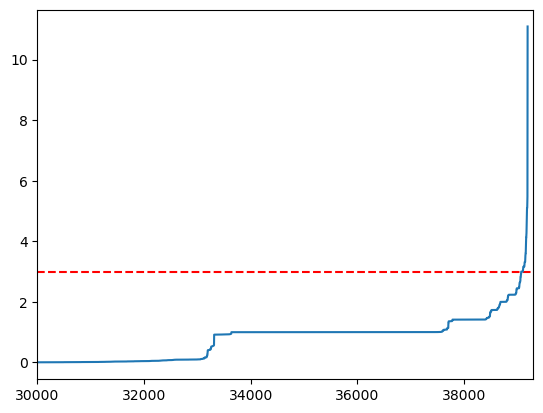

In [26]:
plt.xlim(30000, 39300)
plt.axhline(y=3, color='r', linestyle='--')
plt.plot(distances)


From the (zoomed in) elbow plot, we find that our optimal value of epsilon would be within the range of 2 and 4 for the epsilon.

The minimum samples has a recommendation to take the amount of parameters as its minimum, and we have set the maximum to 10 higher due to time constraints.

We calculate each combination of eps values and minimum sample values, and for each combination we calculate the silhouette score. We will select the combination with the highest silhouette score.

Throughout the process, we found that the range for epsilon was not wide enough, and when we took a wider range of 2 to 10, we found that a value around 8.2 gave the highest score. In order to not have this cell run for a very long time, we have adjusted the range of the score to our found optimum.

In [27]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

# Define a range of eps and min_samples values to test
eps_values = np.arange(8, 8.4, 0.2)  # Adjust the range and step as necessary
min_samples_values = range(9, 10)

# Dictionary to store the results
best_score = -1
best_params = {}

for eps in eps_values:
    for min_samples in min_samples_values:
        # Apply DBSCAN
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(df_demo_encoded_no_y)
        
        # Only compute silhouette score if there is more than 1 cluster
        if len(set(labels)) > 1:
            score = silhouette_score(df_demo_encoded_no_y, labels)
            print(f"eps: {eps}, min_samples: {min_samples}, silhouette score: {score}")
            
            # Check if this is the best score
            if score > best_score:
                best_score = score
                best_params = {'eps': eps, 'min_samples': min_samples}

print(f"Best params: {best_params}, Best silhouette score: {best_score}")


eps: 8.0, min_samples: 9, silhouette score: 0.5972067797400716
eps: 8.2, min_samples: 9, silhouette score: 0.5972895546110909
eps: 8.399999999999999, min_samples: 9, silhouette score: 0.5972895546110909
Best params: {'eps': 8.2, 'min_samples': 9}, Best silhouette score: 0.5972895546110909


Using the calculated best parameters, we will create the DBSCAN clusters using sklearn.cluster.DBSCAN. We will add these clusters to the full dataset, so the dataset in which the column 'y' is included.

In [28]:
# Run DBSCAN clustering
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=best_params['eps'], min_samples=best_params['min_samples'])

df_demo_encoded['dbscan_cluster'] = dbscan.fit_predict(df_demo_encoded_no_y)

C:\Users\20201222\AppData\Local\Temp\ipykernel_22332\3054764320.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_demo_encoded['dbscan_cluster'] = dbscan.fit_predict(df_demo_encoded_no_y)


Check how many different clusters are created

In [29]:
(df_demo_encoded['dbscan_cluster'].unique())

array([ 0,  1, -1,  2,  3,  4,  5,  6,  7,  8], dtype=int64)

We would like to create the cluster plots without the 'y' column, so we will create a new dataframe in which it's dropped.

In [30]:
df_demo_encoded_dbscan = df_demo_encoded.drop(['y'], axis=1)

For our convenience, we will create the variable 'dbscan_features', which includes the exploratory variables that we will include.

In [31]:
dbscan_features = ['age', 'job', 'marital', 'education', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

Here is where we will plot the DBSCAN clusters for all variables, using the previously created dataframe.

c:\Users\20201222\AppData\Local\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


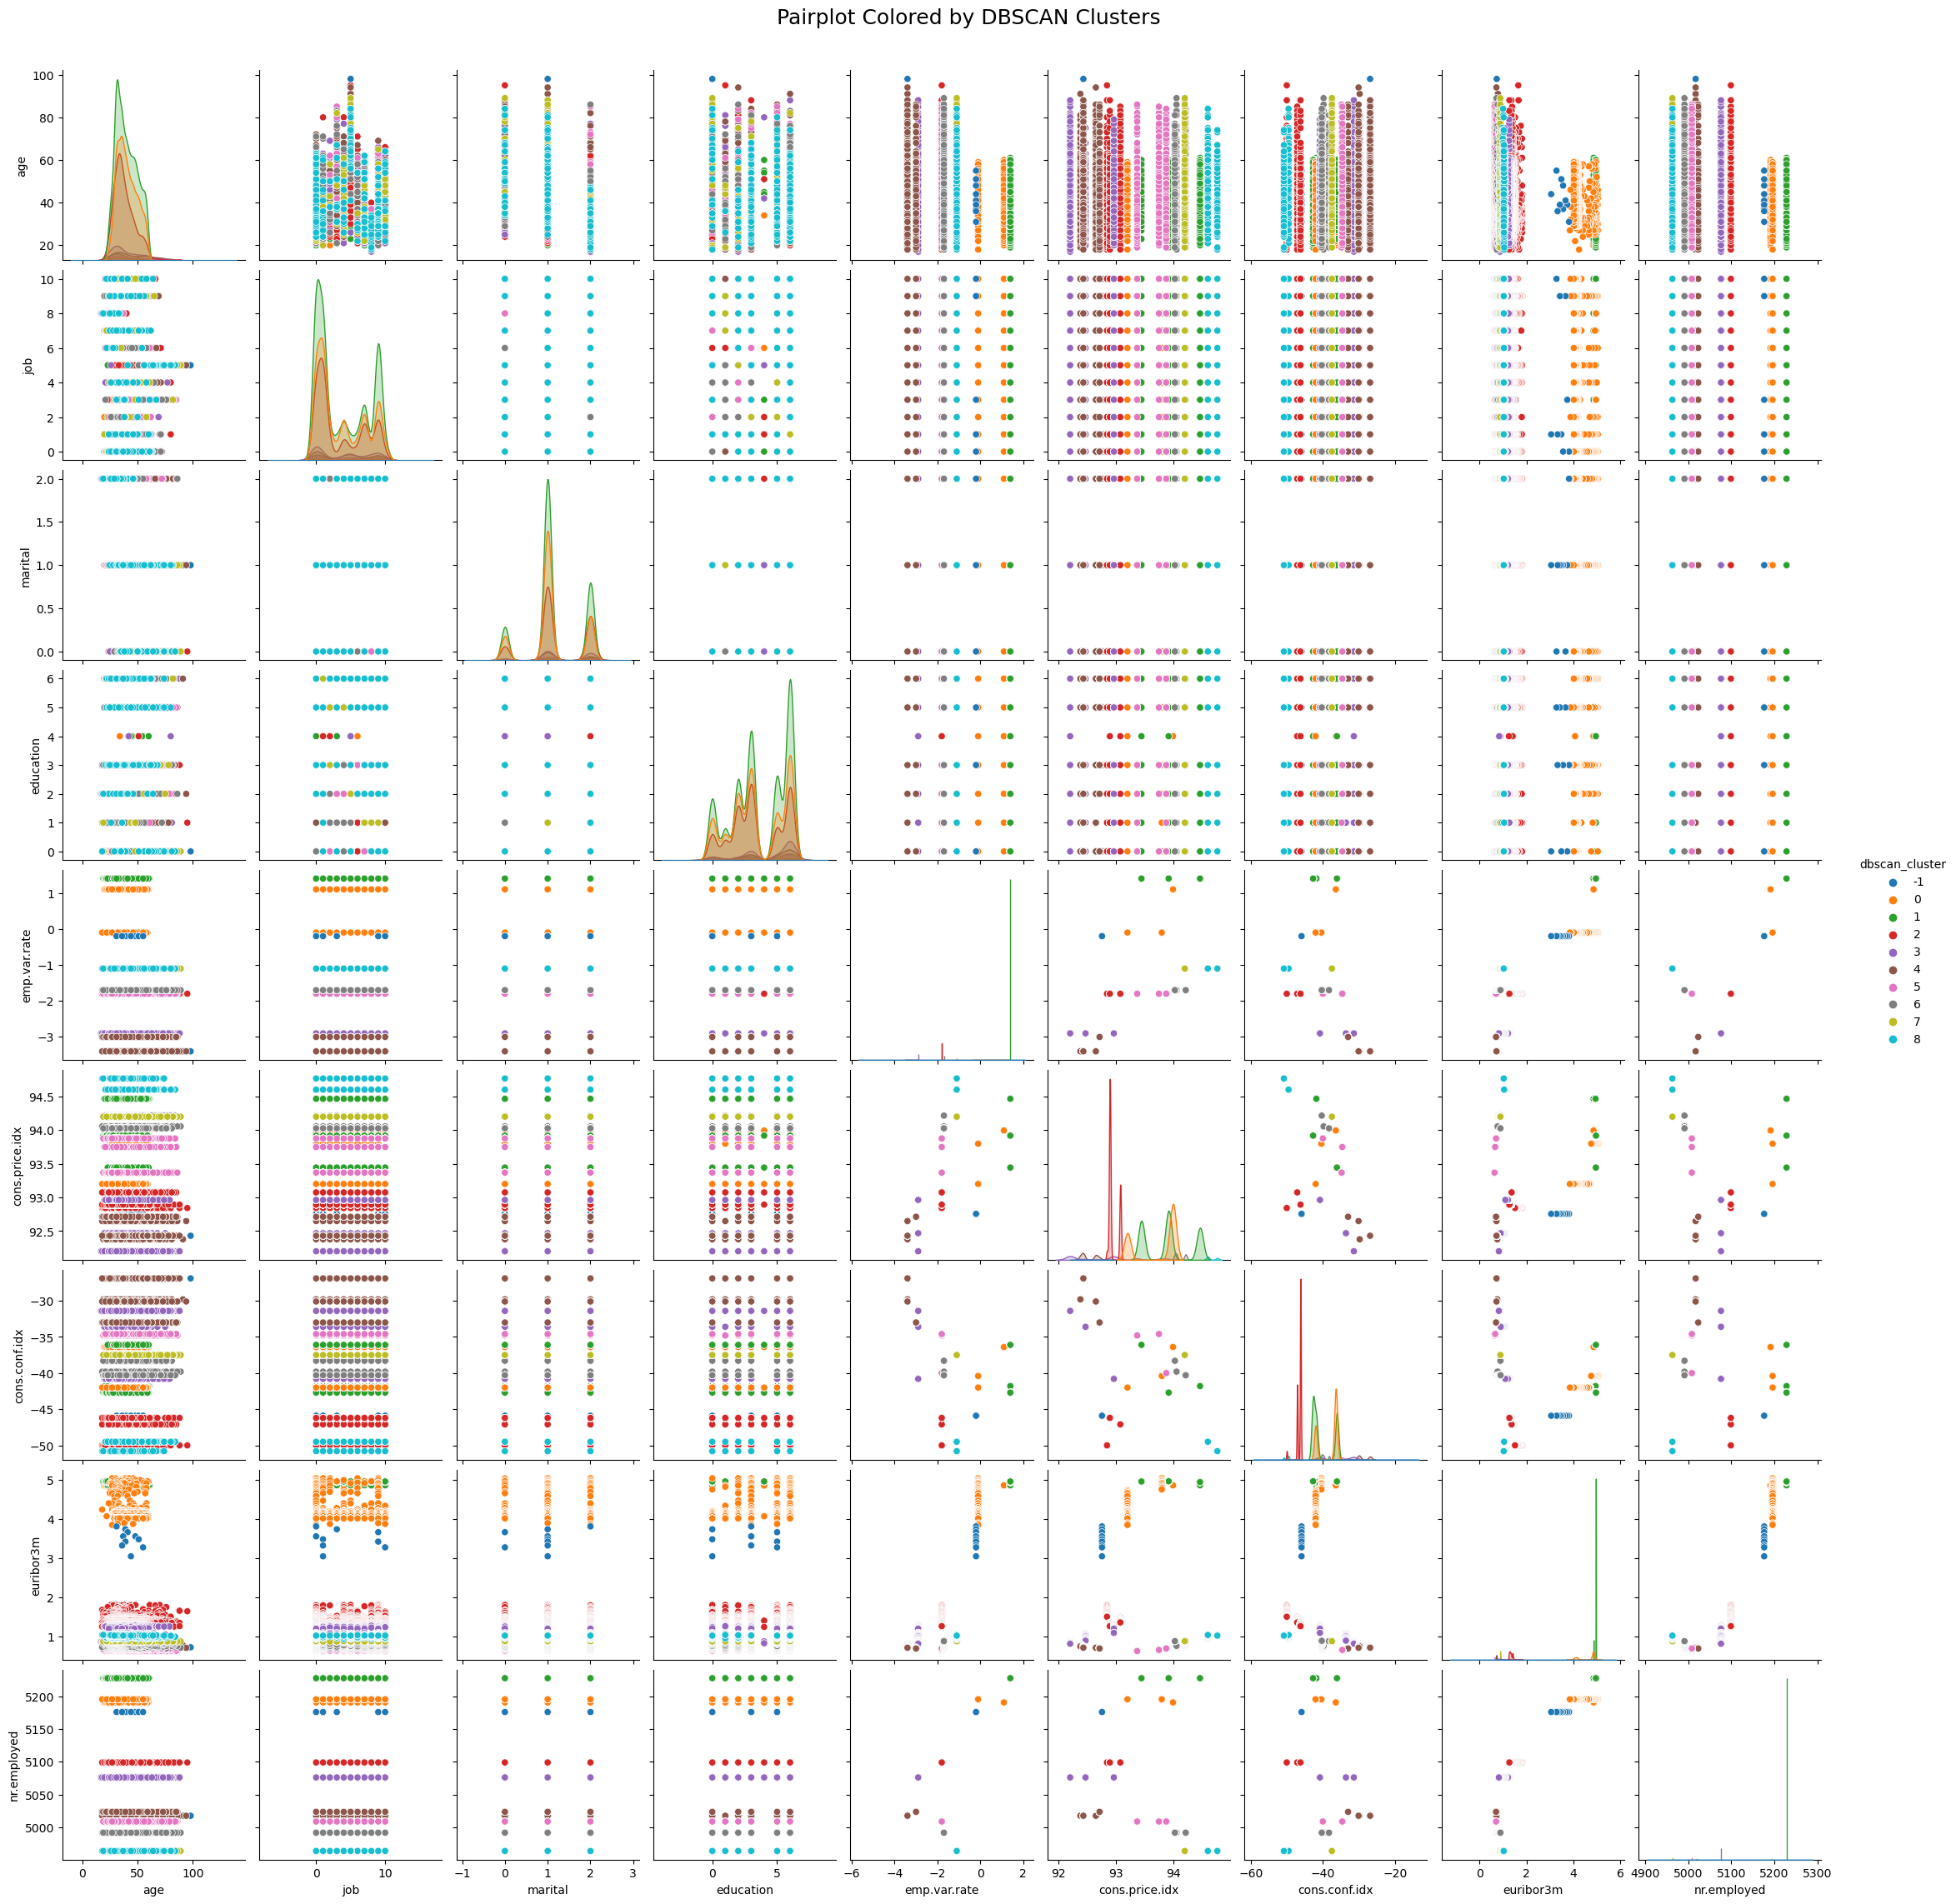

In [32]:
# Plot the pairplot with hue based on the DBSCAN clusters
sns.pairplot(df_demo_encoded_dbscan, vars=df_demo_encoded_dbscan[dbscan_features], 
             hue='dbscan_cluster', palette='tab10')
plt.suptitle("Pairplot Colored by DBSCAN Clusters", y=1.02, size=18)
plt.show()

We have found 8 informative clusters, as the cluster denoted as '-1' is considered the 'noise' cluster. We will remove it to inspect the clusters further.

c:\Users\20201222\AppData\Local\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


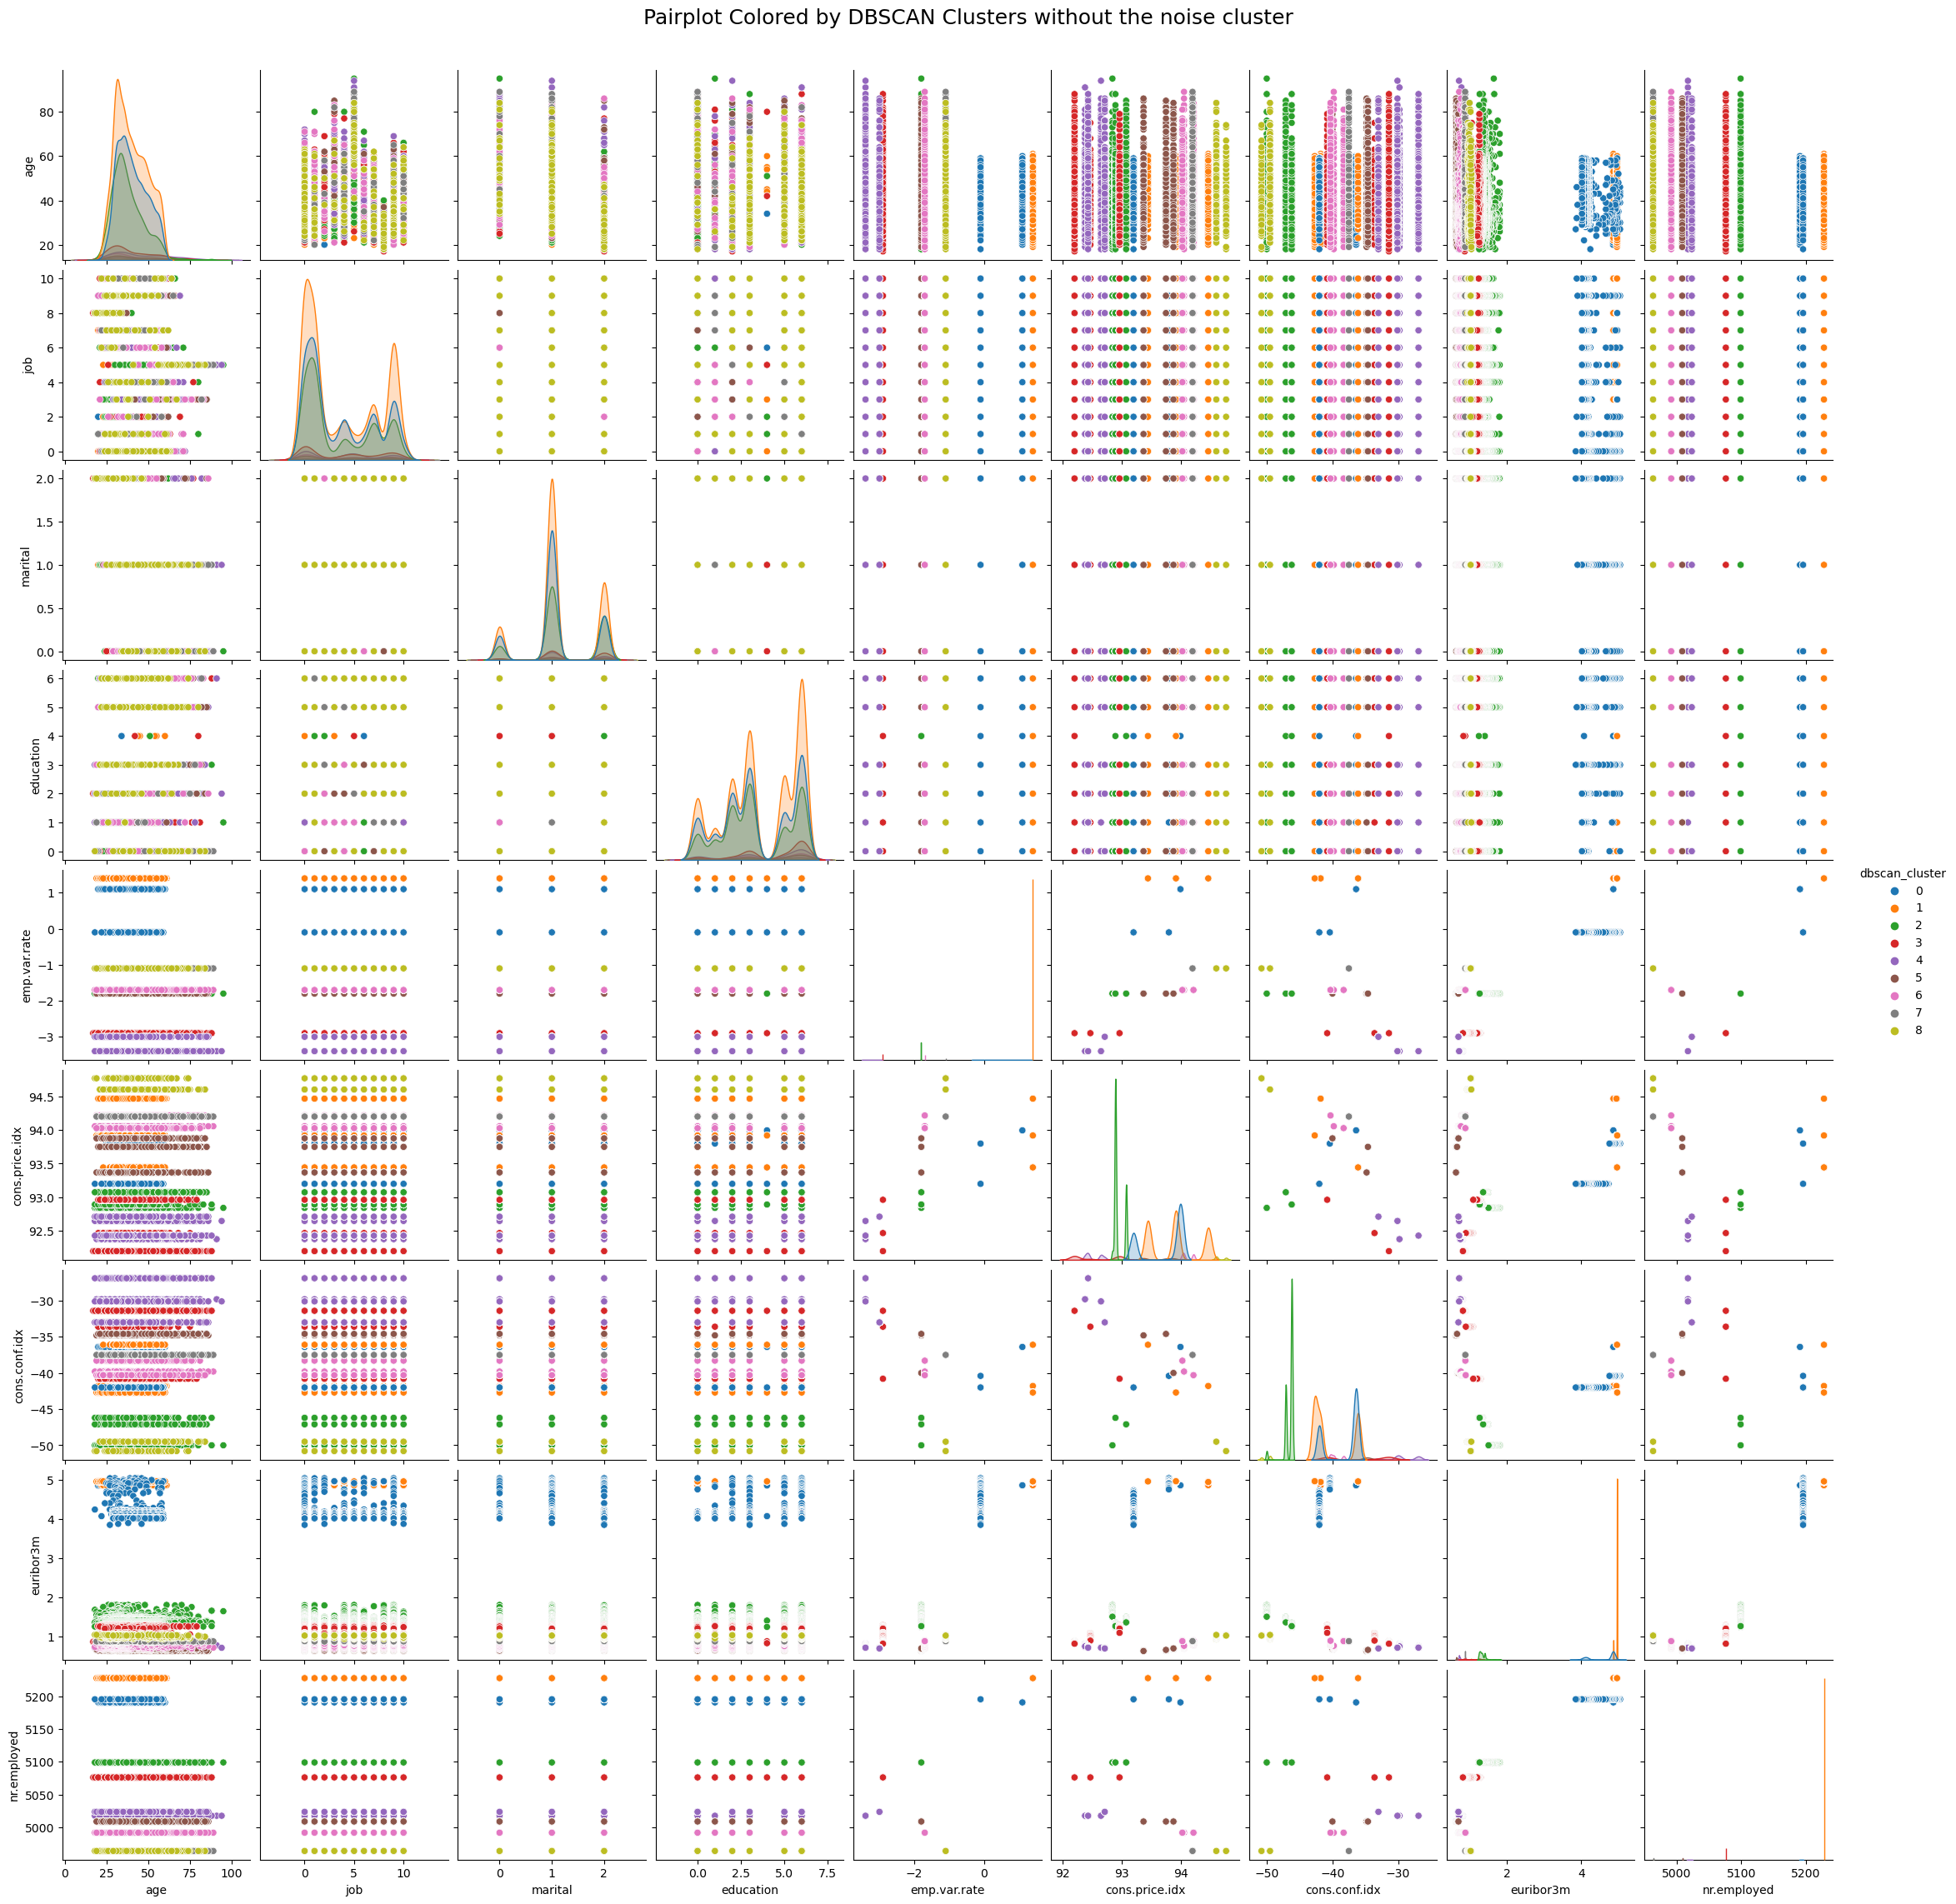

In [33]:
df_dbscan_no_noise = df_demo_encoded_dbscan[df_demo_encoded_dbscan['dbscan_cluster'] != -1]

# Plot the pairplot with hue based on the DBSCAN clusters
sns.pairplot(df_dbscan_no_noise, vars=df_dbscan_no_noise[dbscan_features], 
             hue='dbscan_cluster', palette='tab10')
plt.suptitle("Pairplot Colored by DBSCAN Clusters without the noise cluster", y=1.02, size=18)
plt.show()

We notice that the clusters are not as well-defined as we would like them to be. Some plots do have clear clusters that seem to make sense, such as education and nr. employed, where the clusters seem to be based mostly on the nr. employed. Most plots however do not seem to have clear subgroups, making it difficult to derive insights from the DBSCAN plots.

Now we will check the silhouette scores of the DBSCAN clusters. The silhouette score is a score between -1 and 1, where a number closer to the positive 1 denotes better fitting clusters. 

In [34]:
dbscan_silhouette_score_no_noise = silhouette_score(df_dbscan_no_noise, df_dbscan_no_noise['dbscan_cluster'])
print('Silhouette score for the DBSCAN clusters without noise:', dbscan_silhouette_score_no_noise)
print('Silhouette score for the DBSCAN clusters with noise:', best_score)

Silhouette score for the DBSCAN clusters without noise: 0.597817014695323
Silhouette score for the DBSCAN clusters with noise: 0.5972895546110909


Both scores score around the 0.59, which is not a bad score considering the range of the silhouette score.

We have a slightly smaller score when including the noise. Therefore, the noise may not make such a large difference. This could be due to a very small amount of noise:

In [35]:
print('Amount of rows where the row is defined as noise for clustering:', len(df_demo_encoded_dbscan[df_demo_encoded_dbscan['dbscan_cluster'] == -1]))

Amount of rows where the row is defined as noise for clustering: 12


### Cluster algorithm 2  - Fuzzy C-Means Clustering

In [36]:
# Defining the cluster_range and accuracies for plotting process
cluster_range = range(2,11)
scores = []
all_clusters = []
data = df_demo_encoded_no_y

# Perform Fuzzy C-Means clustering for each number of clusters
for n_clusters in cluster_range:
    # Perform fuzzy C-means clustering
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(df_demo_encoded_no_y.T, n_clusters, 2, error=0.005, maxiter=1000)
    
    # Assign clusters based on the highest membership
    clusters = np.argmax(u, axis=0)
    all_clusters.append(clusters)

    # Calculate silhouette scores
    score = silhouette_score(df_demo_encoded_no_y, clusters)
    scores.append(score)

print(scores)

[0.7683152401116689, 0.6390098282846148, 0.6901503786339994, 0.6235158348241123, 0.5877516077538684, 0.4949163592633806, 0.40347678676307164, 0.4530448838215321, 0.3916137127518571]


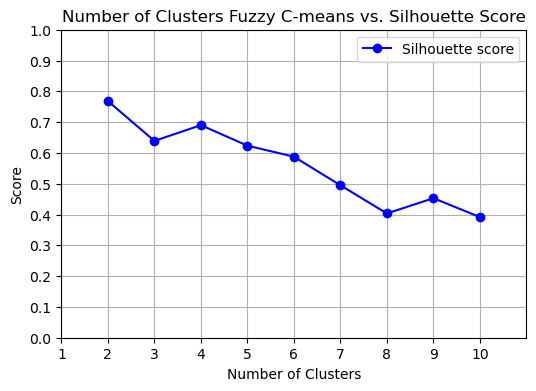

In [37]:
# Plotting number of clusters vs. silhouette scores
plt.figure(figsize=(6, 4))
plt.plot(cluster_range, scores, marker='o', color='b', label="Silhouette score")
plt.title("Number of Clusters Fuzzy C-means vs. Silhouette Score")
plt.xlabel("Number of Clusters")
plt.ylabel("Score")
plt.xlim(1, 11)  # Setting x-axis limit
plt.ylim(0, 1)  # Setting y-axis limit
plt.xticks(range(1, 11))  # Setting x-ticks every 1 increment
plt.yticks(np.arange(0, 1.1, 0.1))  # Setting y-ticks every 0.1 increment
plt.grid()
plt.legend()

plt.show()

When we set the number of clusters to 2, we get the highest silhouette score of 0.7683152401116689. Therefore, we use this value for the final fuzzy c-means interpretation.

C:\Users\20201222\AppData\Local\Temp\ipykernel_22332\720110903.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_demo_encoded['fuzzy_cluster'] = clusters
c:\Users\20201222\AppData\Local\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


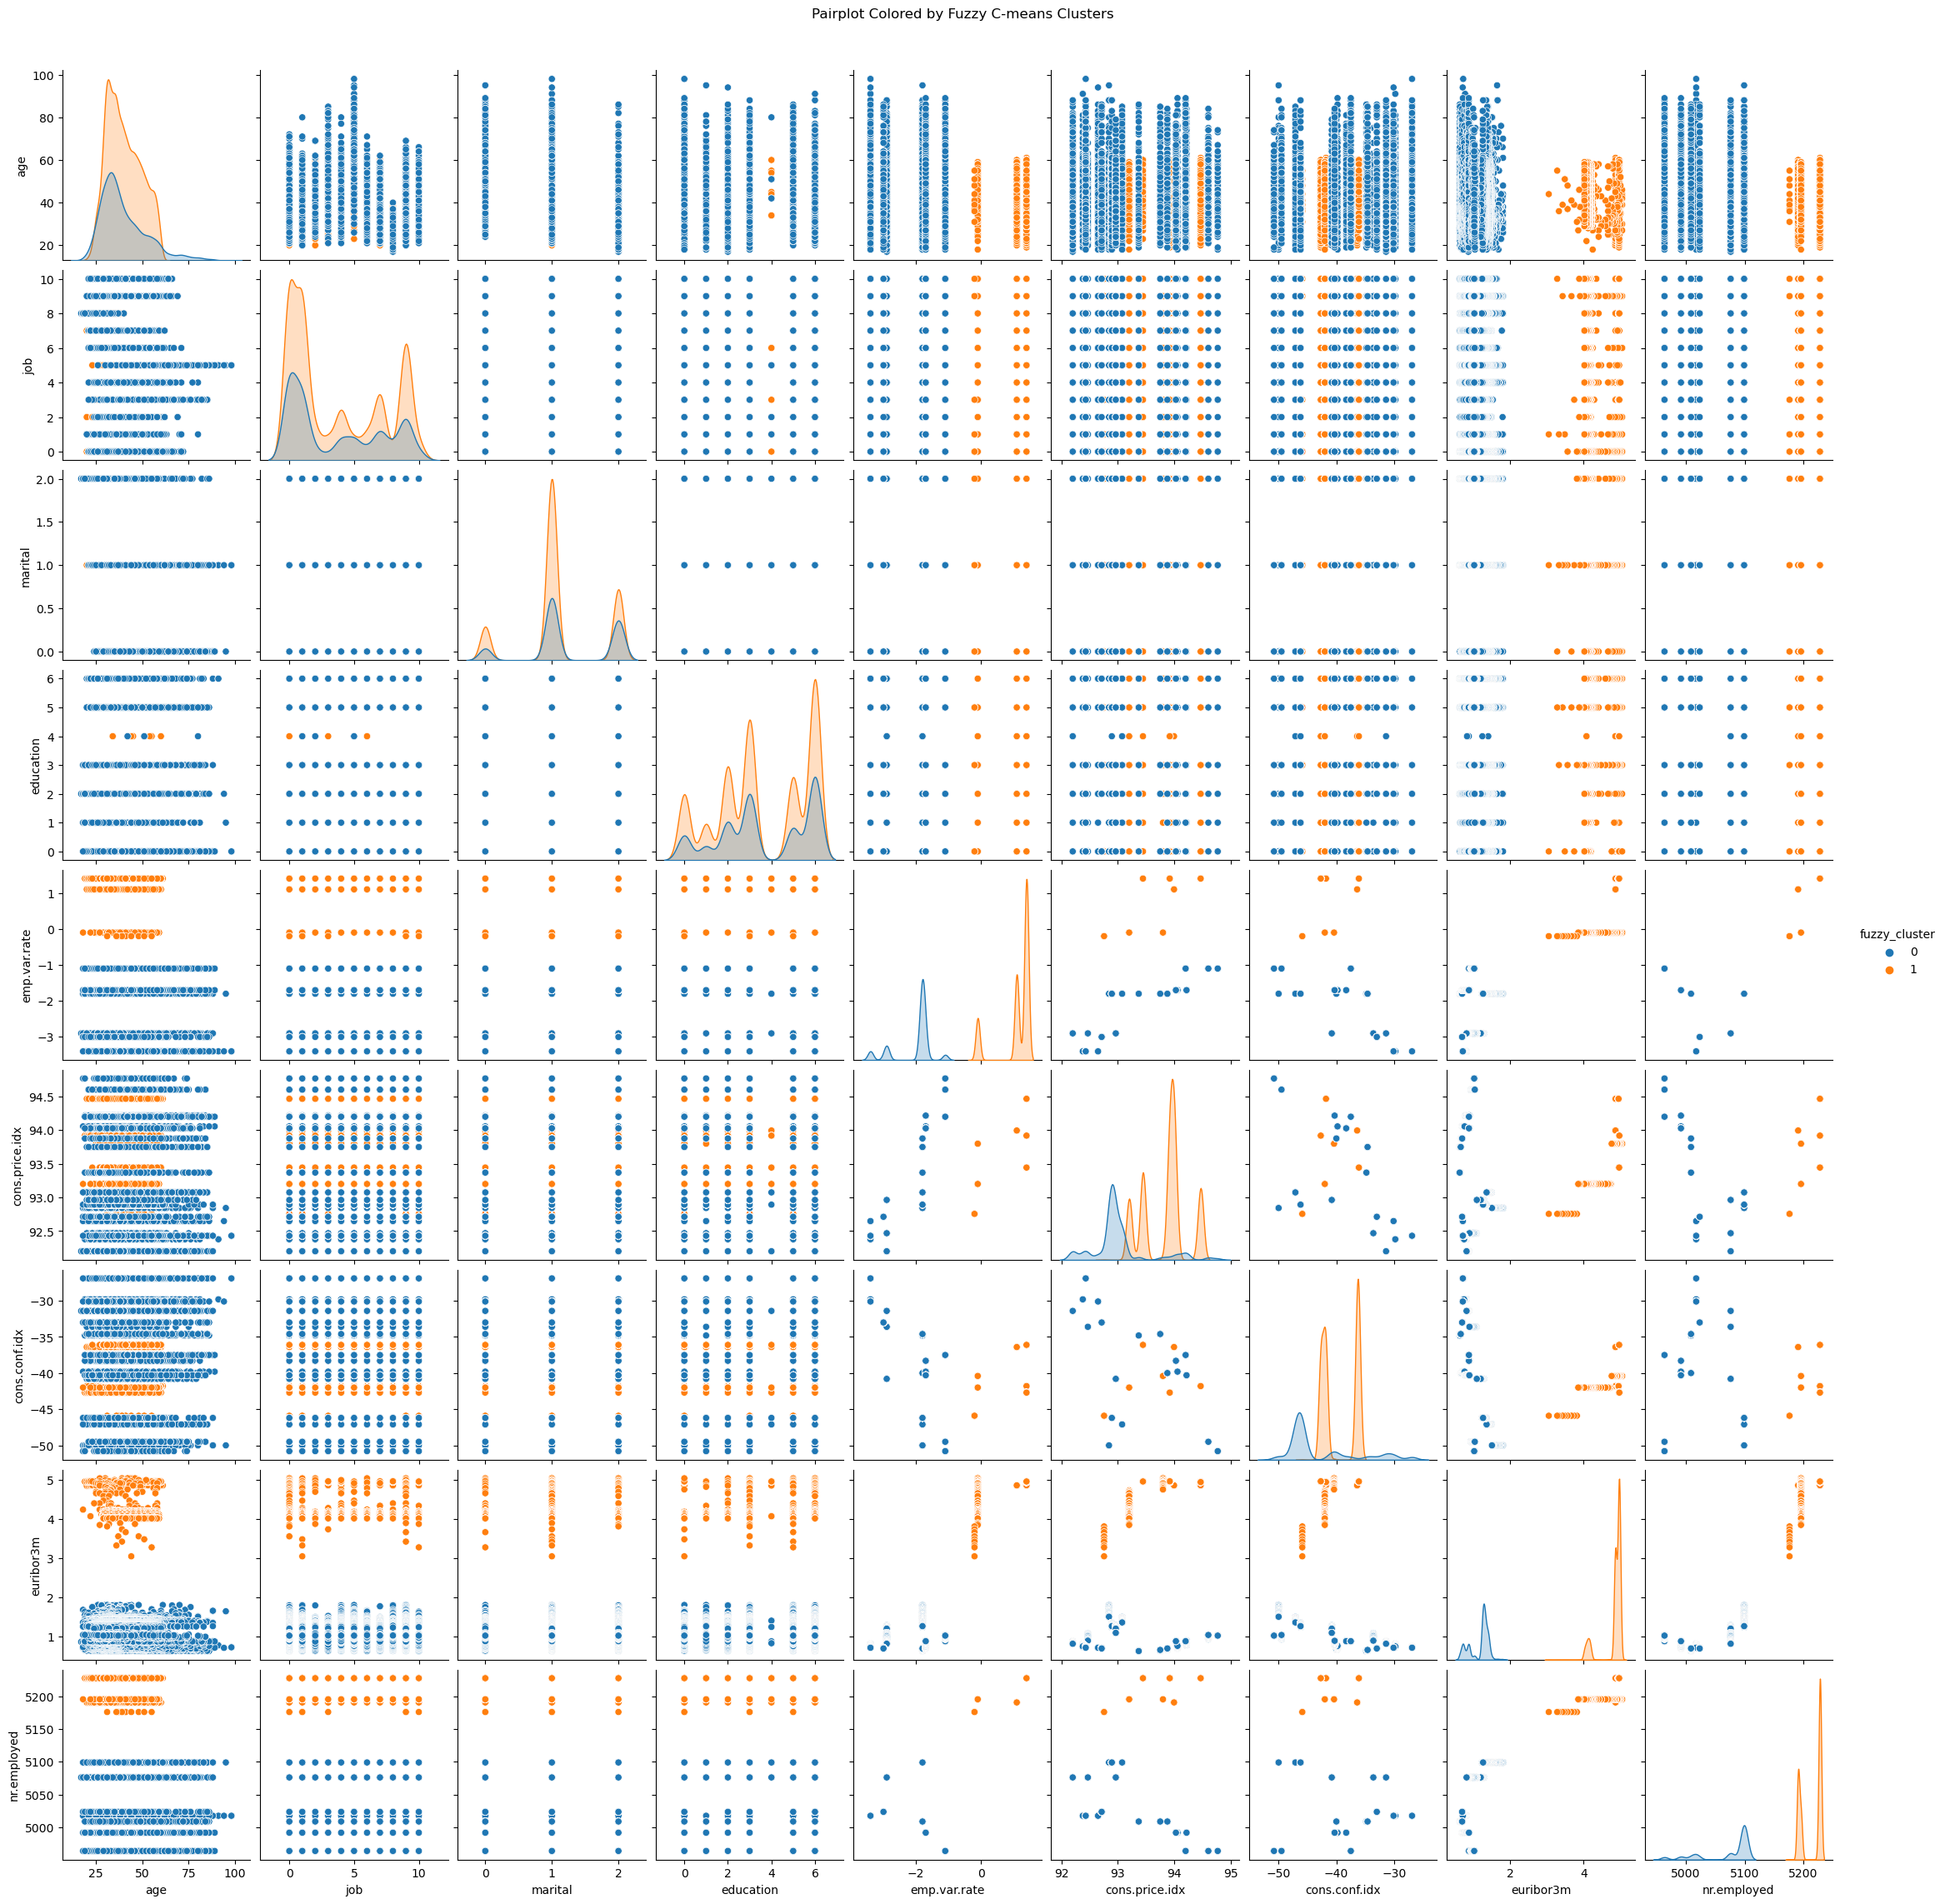

In [38]:
# Perform fuzzy c-means clustering with 2 clusters
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(data.T, c=2, m=2, error=0.005, maxiter=1000)
clusters = np.argmax(u, axis=0)

# Add the cluster assignment to the dataframe
df_demo_encoded['fuzzy_cluster'] = clusters

# Plot the clusters using pairplot
sns.pairplot(df_demo_encoded, vars=df_demo_encoded_no_y.columns, 
             hue='fuzzy_cluster', palette='tab10')
plt.suptitle("Pairplot Colored by Fuzzy C-means Clusters", y=1.02)
plt.show()

In [39]:
# return cluster centers cntr 
print(f"Clusters centers: {cntr}")
# return membership matrix u
print(f"Memership matrix: {u}")

Clusters centers: [[ 3.93209392e+01  3.62300812e+00  1.24784910e+00  3.67532951e+00
  -2.04010236e+00  9.29968190e+01 -4.28460463e+01  1.19055777e+00
   5.07581732e+03]
 [ 3.99889373e+01  3.65728648e+00  1.13129686e+00  3.58226813e+00
   1.10950570e+00  9.38370305e+01 -3.95019461e+01  4.80709477e+00
   5.21334526e+03]]
Memership matrix: [[0.05405548 0.05597933 0.03814393 ... 0.82905596 0.83112765 0.82118812]
 [0.94594452 0.94402067 0.96185607 ... 0.17094404 0.16887235 0.17881188]]


### Clustering Interpretation

## Association rules

We would like to see the implications of certain variables to other variables. Therefore, we will look into the association rules of our dataset.

However, we typically need categorical data for the method that we would like to use: apriori. Therefore, we will segment the numerical variables that we have chosen in order to still include them. We will do this using equal-width bins, in order to keep the distribution of the original data. We will only apply this to the numerical variables where the variety in values is high enough for us to deem it necessary. For example, emp.var.rate has a limited amount of possibilities, which makes it fine to not bin it.

For the association rules, we want to make use of df_demo, as we are able to use the unencoded data.

In [208]:
df_ass_rules = df_demo
df_ass_rules

age          job  marital            education  emp.var.rate  \
0       56    housemaid  married             basic.4y           1.1   
1       57     services  married          high.school           1.1   
2       37     services  married          high.school           1.1   
3       40       admin.  married             basic.6y           1.1   
4       56     services  married          high.school           1.1   
...    ...          ...      ...                  ...           ...   
41183   73      retired  married  professional.course          -1.1   
41184   46  blue-collar  married  professional.course          -1.1   
41185   56      retired  married    university.degree          -1.1   
41186   44   technician  married  professional.course          -1.1   
41187   74      retired  married  professional.course          -1.1   

       cons.price.idx  cons.conf.idx  euribor3m  nr.employed    y  
0              93.994          -36.4      4.857       5191.0   no  
1              93.994          -36.4      4.857       5191.0   no  
2              93.994          -36.4      4.857       5191.0   no  
3              93.994          -36.4      4.857       5191.0   no  
4              93.994          -36.4      4.857       5191.0   no  
...               ...            ...        ...          ...  ...  
41183          94.767          -50.8      1.028       4963.6  yes  
41184          94.767          -50.8      1.028       4963.6   no  
41185          94.767          -50.8      1.028       4963.6   no  
41186          94.767          -50.8      1.028       4963.6  yes  
41187          94.767          -50.8      1.028       4963.6   no  

[41188 rows x 10 columns]

#### Translation of the categories to their actual values

In [ ]:
# Categories for age
count = 1
for interval in pd.qcut(df_ass_rules['age'], q=5).cat.categories:
        print('Age category', count, ':', interval)
        count +=1

Age category 1 : (16.999, 31.0]
Age category 2 : (31.0, 35.0]
Age category 3 : (35.0, 41.0]
Age category 4 : (41.0, 49.0]
Age category 5 : (49.0, 98.0]


In [ ]:
# Categories for emp.var.rate
count = 1
for interval in pd.qcut(df_ass_rules['emp.var.rate'], q=3).cat.categories:
        print('emp.var.rate category', count, ':', interval)
        count +=1

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [252]:
# Categories for cons.price.idx
count = 1
for interval in pd.qcut(df_ass_rules['cons.price.idx'], q=3).cat.categories:
        print('cons.price.idx category', count, ':', interval)
        count +=1

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [253]:
# Categories for cons.conf.idx
count = 1
for interval in pd.qcut(df_ass_rules['cons.conf.idx'], q=3).cat.categories:
        print('cons.conf.idx category', count, ':', interval)
        count +=1

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [ ]:
# Categories for euribor3m
count = 1
for interval in pd.qcut(df_ass_rules['euribor3m'], q=10).cat.categories:
        print('euribor3m category', count, ':', interval)
        count +=1

In [ ]:
# Categories for nr. employed
count = 1
for interval in pd.qcut(df_ass_rules['nr.employed'], q=3).cat.categories:
        print('nr.employed category', count, ':', interval)
        count +=1

#### Encoding the numerical variables to categorical variables

In [211]:
# Encoding of age
num_bins = 5
labels = ['Category ' + str(i+1) for i in range(num_bins)]  # Create labels for the bins

# Use pd.cut to categorize 'age' into 5 equal-width bins
df_ass_rules['age'] = pd.cut(df_ass_rules['age'], bins=num_bins, labels=labels)


C:\Users\20202631\AppData\Local\Temp\ipykernel_14232\385134539.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ass_rules['age'] = pd.cut(df_ass_rules['age'], bins=num_bins, labels=labels)


In [248]:
# Encoding of cons.price.idx
num_bins = 3
labels = ['Category ' + str(i+1) for i in range(num_bins)]  # Create labels for the bins

# Use pd.cut to categorize 'age' into 5 equal-width bins
df_ass_rules['cons.price.idx'] = pd.cut(df_ass_rules['cons.price.idx'], bins=num_bins, labels=labels)

TypeError: can only concatenate str (not "float") to str

In [249]:
# Encoding of cons.conf.idx
num_bins = 3
labels = ['Category ' + str(i+1) for i in range(num_bins)]  # Create labels for the bins

# Use pd.cut to categorize 'age' into 5 equal-width bins
df_ass_rules['cons.conf.idx'] = pd.cut(df_ass_rules['cons.conf.idx'], bins=num_bins, labels=labels)

C:\Users\20202631\AppData\Local\Temp\ipykernel_14232\1041307201.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ass_rules['cons.conf.idx'] = pd.cut(df_ass_rules['cons.conf.idx'], bins=num_bins, labels=labels)


In [212]:
# Encoding of euribor3m
num_bins = 10
labels = ['Category ' + str(i+1) for i in range(num_bins)]  # Create labels for the bins

# Use pd.cut to categorize 'age' into 5 equal-width bins
df_ass_rules['euribor3m'] = pd.cut(df_ass_rules['euribor3m'], bins=num_bins, labels=labels)


C:\Users\20202631\AppData\Local\Temp\ipykernel_14232\4126262756.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ass_rules['euribor3m'] = pd.cut(df_ass_rules['euribor3m'], bins=num_bins, labels=labels)


In [243]:
# Encoding of nr.employed
num_bins = 3
labels = ['Category ' + str(i+1) for i in range(num_bins)]  # Create labels for the bins

# Use pd.cut to categorize 'age' into 5 equal-width bins
df_ass_rules['nr.employed'] = pd.cut(df_ass_rules['nr.employed'], bins=num_bins, labels=labels)

C:\Users\20202631\AppData\Local\Temp\ipykernel_14232\2191617595.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ass_rules['nr.employed'] = pd.cut(df_ass_rules['nr.employed'], bins=num_bins, labels=labels)


This is our final encoded dataset, so we can use it for the apriori algorithm.

In [255]:
df_ass_rules.head()

age        job  marital    education emp.var.rate cons.price.idx  \
0  Category 3  housemaid  married     basic.4y   Category 3     Category 3   
1  Category 3   services  married  high.school   Category 3     Category 3   
2  Category 2   services  married  high.school   Category 3     Category 3   
3  Category 2     admin.  married     basic.6y   Category 3     Category 3   
4  Category 3   services  married  high.school   Category 3     Category 3   

  cons.conf.idx    euribor3m nr.employed   y  
0    Category 2  Category 10  Category 3  no  
1    Category 2  Category 10  Category 3  no  
2    Category 2  Category 10  Category 3  no  
3    Category 2  Category 10  Category 3  no  
4    Category 2  Category 10  Category 3  no

The bins that were selected were based on the amount of variety in each variable. The ones that had very little variety received 3 bins, medium 5 and a large amount of variety resulted in 10 bins.

#### Checking the bar plots of our categories

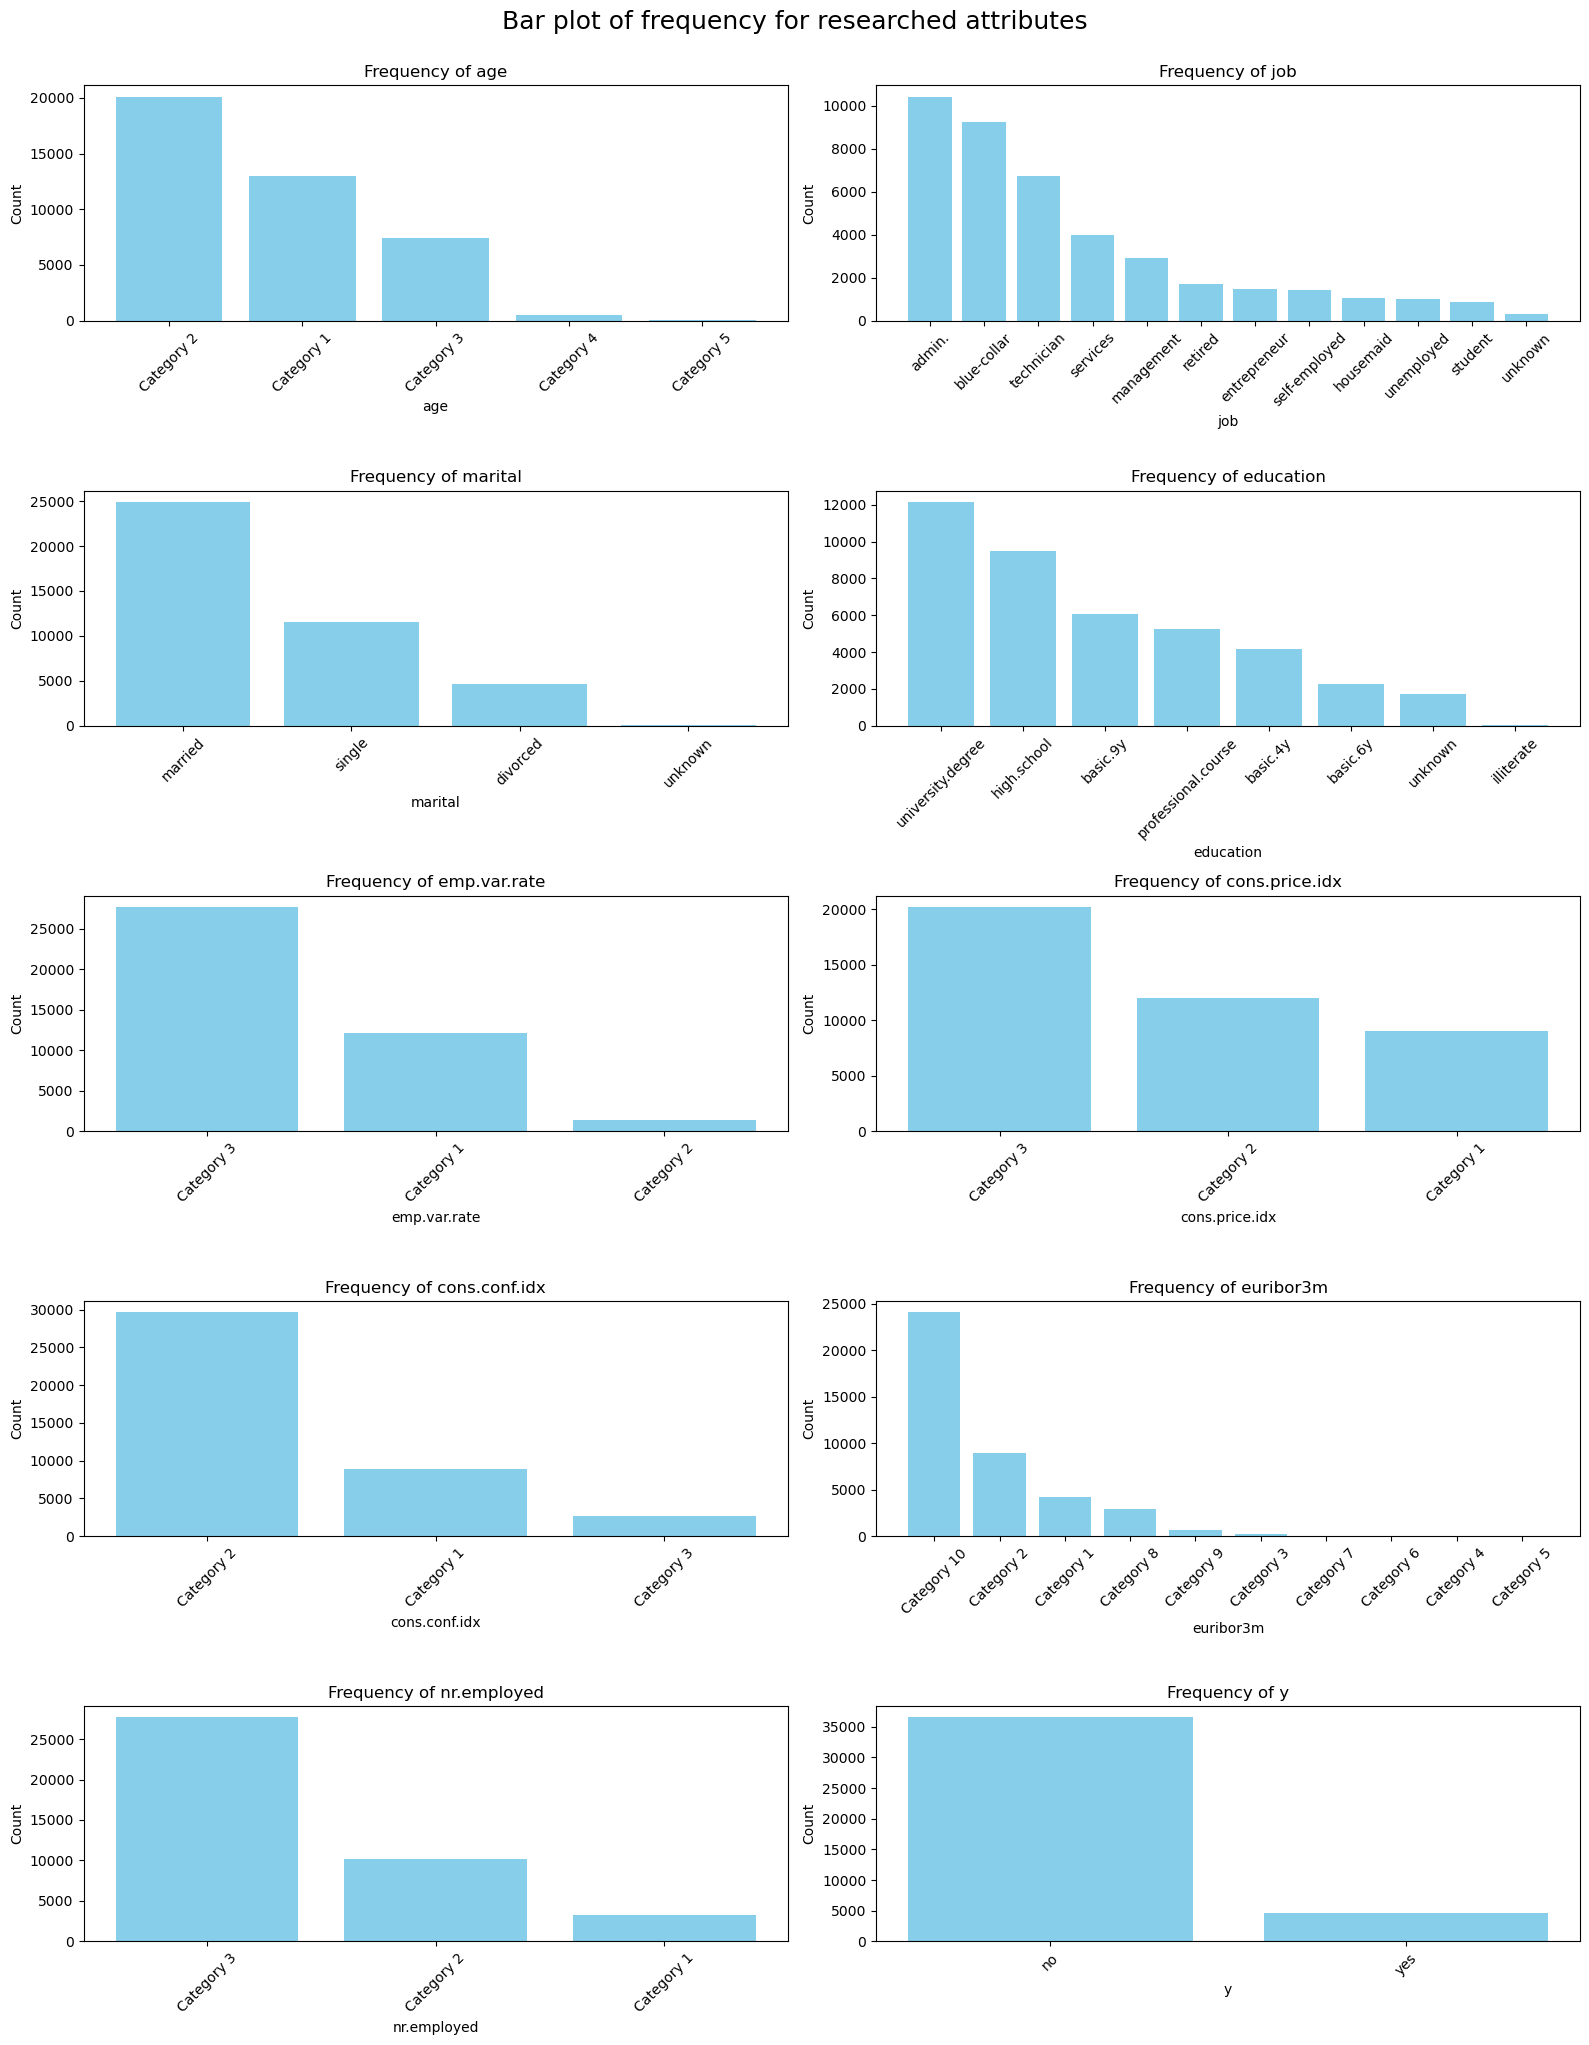

In [256]:
ass_rules_features = dbscan_features + ['y']

fig, ax = plt.subplots(5, 2, figsize=(16, 20))

# Flatten the axes to make it easier to loop through
ax = ax.flatten()

# Loop through the categorical columns and create bar plots
for i, column in enumerate(ass_rules_features):
    # Get the counts of each category in the column
    value_counts = df_ass_rules[column].value_counts()
    
    # Plot the bar plot for the current column
    ax[i].bar(value_counts.index.astype(str), value_counts, color='skyblue')
    ax[i].set_title(f'Frequency of {column}')
    ax[i].set_xlabel(column)
    ax[i].set_ylabel('Count')
    ax[i].tick_params(axis='x', rotation=45)  # Rotate x-axis labels for better readability

# Adjust the layout to avoid overlap
plt.tight_layout()
fig.suptitle('Bar plot of frequency for researched attributes', y=1.02, size=18)
# Show the plots
plt.show()


From the bar plot, we notice that some 'items' are much more frequent than others, which could lead to intersting association rules.

In order to implement the apriori algorithm, we will need to apply some data preprocessing. All the values need to be 0 or 1 for it to work, so we will use the 'get_dummies' algorithm from python to ensure this.

In [265]:
from mlxtend.frequent_patterns import apriori, association_rules

df_ass_rules = pd.get_dummies(df_ass_rules)
df_ass_rules.head()

age_Category 1  age_Category 2  age_Category 3  age_Category 4  \
0               0               0               1               0   
1               0               0               1               0   
2               0               1               0               0   
3               0               1               0               0   
4               0               0               1               0   

   age_Category 5  job_admin.  job_blue-collar  job_entrepreneur  \
0               0           0                0                 0   
1               0           0                0                 0   
2               0           0                0                 0   
3               0           1                0                 0   
4               0           0                0                 0   

   job_housemaid  job_management  ...  euribor3m_Category 6  \
0              1               0  ...                     0   
1              0               0  ...                     0   
2              0               0  ...                     0   
3              0               0  ...                     0   
4              0               0  ...                     0   

   euribor3m_Category 7  euribor3m_Category 8  euribor3m_Category 9  \
0                     0                     0                     0   
1                     0                     0                     0   
2                     0                     0                     0   
3                     0                     0                     0   
4                     0                     0                     0   

   euribor3m_Category 10  nr.employed_Category 1  nr.employed_Category 2  \
0                      1                       0                       0   
1                      1                       0                       0   
2                      1                       0                       0   
3                      1                       0                       0   
4                      1                       0                       0   

   nr.employed_Category 3  y_no  y_yes  
0                       1     1      0  
1                       1     1      0  
2                       1     1      0  
3                       1     1      0  
4                       1     1      0  

[5 rows x 53 columns]

In [ ]:
# 65% support is used to create a smaller set.
frequent_items = apriori(df_ass_rules, min_support=0.65, use_colnames=True)
frequent_items

c:\Users\20202631\AppData\Local\anaconda3v2\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


support                                           itemsets
0  0.672283                          (emp.var.rate_Category 3)
1  0.720671                         (cons.conf.idx_Category 2)
2  0.672283                           (nr.employed_Category 3)
3  0.887346                                             (y_no)
4  0.672040  (emp.var.rate_Category 3, cons.conf.idx_Catego...
5  0.672283  (emp.var.rate_Category 3, nr.employed_Category 3)
6  0.672040  (cons.conf.idx_Category 2, nr.employed_Categor...
7  0.665388                   (cons.conf.idx_Category 2, y_no)
8  0.672040  (emp.var.rate_Category 3, cons.conf.idx_Catego...

These results indicate how often these itemsets occur in the entire dataset, showing us that for example y_no (meaning that no loan was taken) occurs 88.73% of the time.


In [314]:
rules = association_rules(frequent_items, metric='confidence', min_threshold=0.3)
rules_13 = rules.sort_values(["support", "confidence","lift"],axis = 0, ascending = False).head(13)
rules_13

antecedents  \
2                           (emp.var.rate_Category 3)   
3                            (nr.employed_Category 3)   
8   (emp.var.rate_Category 3, cons.conf.idx_Catego...   
10  (cons.conf.idx_Category 2, nr.employed_Categor...   
11                          (emp.var.rate_Category 3)   
13                           (nr.employed_Category 3)   
0                           (emp.var.rate_Category 3)   
5                            (nr.employed_Category 3)   
9   (emp.var.rate_Category 3, nr.employed_Category 3)   
1                          (cons.conf.idx_Category 2)   
4                          (cons.conf.idx_Category 2)   
12                         (cons.conf.idx_Category 2)   
6                          (cons.conf.idx_Category 2)   

                                          consequents  antecedent support  \
2                            (nr.employed_Category 3)            0.672283   
3                           (emp.var.rate_Category 3)            0.672283   
8                            (nr.employed_Category 3)            0.672040   
10                          (emp.var.rate_Category 3)            0.672040   
11  (cons.conf.idx_Category 2, nr.employed_Categor...            0.672283   
13  (emp.var.rate_Category 3, cons.conf.idx_Catego...            0.672283   
0                          (cons.conf.idx_Category 2)            0.672283   
5                          (cons.conf.idx_Category 2)            0.672283   
9                          (cons.conf.idx_Category 2)            0.672283   
1                           (emp.var.rate_Category 3)            0.720671   
4                            (nr.employed_Category 3)            0.720671   
12  (emp.var.rate_Category 3, nr.employed_Category 3)            0.720671   
6                                              (y_no)            0.720671   

    consequent support   support  confidence      lift  leverage  conviction  \
2             0.672283  0.672283    1.000000  1.487468  0.220319         inf   
3             0.672283  0.672283    1.000000  1.487468  0.220319         inf   
8             0.672283  0.672040    1.000000  1.487468  0.220239         inf   
10            0.672283  0.672040    1.000000  1.487468  0.220239         inf   
11            0.672040  0.672040    0.999639  1.487468  0.220239  908.120132   
13            0.672040  0.672040    0.999639  1.487468  0.220239  908.120132   
0             0.720671  0.672040    0.999639  1.387094  0.187545  773.461809   
5             0.720671  0.672040    0.999639  1.387094  0.187545  773.461809   
9             0.720671  0.672040    0.999639  1.387094  0.187545  773.461809   
1             0.672283  0.672040    0.932520  1.387094  0.187545    4.856524   
4             0.672283  0.672040    0.932520  1.387094  0.187545    4.856524   
12            0.672283  0.672040    0.932520  1.387094  0.187545    4.856524   
6             0.887346  0.665388    0.923289  1.040507  0.025904    1.468561   

    zhangs_metric  
2        1.000000  
3        1.000000  
8        0.999260  
10       0.999260  
11       1.000000  
13       1.000000  
0        0.851554  
5        0.851554  
9        0.851554  
1        0.999068  
4        0.999068  
12       0.999068  
6        0.139370

Taking our 13 highest confidence rules, we find that the values of all these rules are incredibly high. The 14th rule had a confidence if approx. 0.7, which is still relatively high.

We find that most of these rules include nr.employed, cons.conf.idx and emp.var.rate as the consequent. Mainly the higher end of these categories are more frequently occuring.

We can read this table as 'the confidence of a rule tells us how certain we are that if the antecedent is given, the consequent will occur'.

The most interesting rule to note is the rule with as consequent y_no, and as antecendent cons.conf.idx of category 2 (medium), as we are interested in y as our outcome variable. This rule has a confidence of 0.923, which is very high.

In [290]:
# Lift Ratio > 1 indicates good influential rule 
rules[(rules.lift<1)]

Empty DataFrame
Columns: [antecedents, consequents, antecedent support, consequent support, support, confidence, lift, leverage, conviction, zhangs_metric]
Index: []

All of our rules have a positive lift, meaning that there is no negative correlation between our items

### Visalising the confidence

In order to clearly see the rules in one go, we will visualise them using barplots. This will allow us to understand the confidence of the rules more easily.

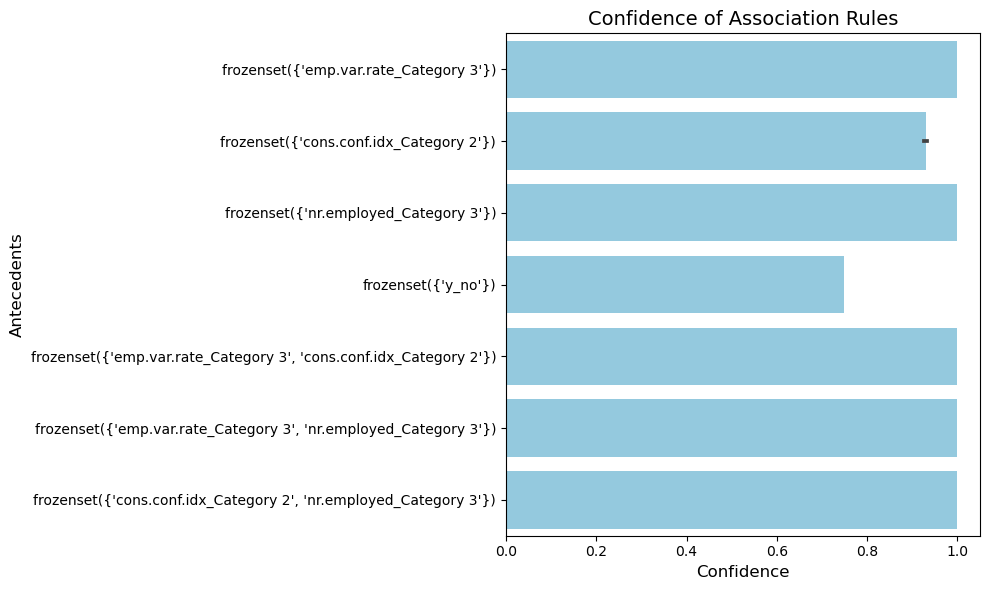

In [295]:
# Create a bar plot for confidence values
plt.figure(figsize=(10, 6))
sns.barplot(x='confidence', y='antecedents', data=rules, color='skyblue')

# Add title and labels
plt.title('Confidence of Association Rules', fontsize=14)
plt.xlabel('Confidence', fontsize=12)
plt.ylabel('Antecedents', fontsize=12)

# Show plot
plt.tight_layout()
plt.show()

From this barplot we can see that the confidence for our rules is very high, and even our lowest ranking rule is still relatively high.

# Predictive Modelling


Now that we have performed EDA, feature engineering, clustering and association rule mining, we will move on to the predictive modelling part of the assignment. We will be using the following models:
- Support Vector Machine (SVM)
- eXtreme Gradient Boosting (XGBoost)
- Random Forest

These models were chosen because they are known to perform well on imbalanced datasets, which we have. We will be using the AUC as our evaluation metric, as it is a better metric for imbalanced datasets than accuracy. After evluating all models the best performing will be chosen and finetuned for optimal performance.

First, we split the data into train and test data. We will use 80% of the data for training and 20% for testing. We will then train the models on the training data and evaluate them on the test data.

In [ ]:
#Split data into train and test data
from sklearn.model_selection import train_test_split

X = df_demo_encoded.drop('y', axis=1)
y = df_demo_encoded['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

SVM (Kyrie)

### XGBoost (Onno)

XGBoost (Extreme Gradient Boosting) is a powerful and efficient machine learning algorithm based on the gradient boosting framework. It builds a strong model by combining many weak learners, in our case decision trees, in an iterative way to minimize prediction errors. With each iteration, XGBoost focuses on improving the accuracy by adjusting for errors made in previous rounds, which leads to high performance and accuracy.

First, the optimal hyperparameters (optimizing for XXXXX) will be determined using Grid search Cross Validation. Then an XGBoost model will be trained on these parameters. Finally, in the evaluation section, the model will be evaluated on the test set and compared to the other two models in this notebook.

In [ ]:
#Import necessary libraries for XGBoost
from xgboost import XGBClassifier

#Import Gridsearch for hyperparameter tuning
from sklearn.model_selection import GridSearchCV

#Initialize the XGBClassifier
xgb = XGBClassifier()

#Initialize the parameter grid
param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 200, 300],
    'gamma': [0, 0.1, 0.2],
}

#Perform grid search with 5-fold cross-validation (~30 seconds)
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, n_jobs=-1, scoring='roc_auc_ovr_weighted')
grid_search.fit(X_train, y_train)

#Print the best parameters
print(grid_search.best_params_)

After finding the best possible parameters for the XGBoost model, we will train it on the training set.

In [ ]:
#Initialize the XGBClassifier with the best parameters
xgb_best = XGBClassifier(**grid_search.best_params_)
xgb_best.fit(X_train, y_train)

In [ ]:
#visualize feature importance
plt.figure(figsize=(4, 4));
plt.title('Feature Importance: XGBoost');
sns.barplot(x=xgb_best.feature_importances_, y=key_features.drop('y'));
plt.xlabel('Feature Importance');
plt.ylabel('Feature');
plt.show()

*[TODO] CONCLUSIE OVER FEATURE IMPORTANCES*

Random Forest (Mila)

# Comparison between the 3 models

In order to compare the performance of the three models, we will use the following metrics: accuracy, precision, recall, F1 score, and ROC AUC score. We will also plot the ROC curve for each model. In the end, the best model will be chosen based on the ROC AUC score as this most accurately represents the performance of the model.

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

SVM performance metrics:

In [ ]:
#Predict the target variable
y_pred_svm = svm_best.predict(X_test)

#Print evaluation measures
print('Accuracy: ', accuracy_score(y_test, y_pred_svm))
print('Precision: ', precision_score(y_test, y_pred_svm))
print('Recall: ', recall_score(y_test, y_pred_svm))
print('F1 Score: ', f1_score(y_test, y_pred_svm))
print('ROC AUC Score: ', roc_auc_score(y_test, y_pred_svm))

#Visualize confusion matrix
plt.figure(figsize=(8, 6));
plt.title('Confusion Matrix: XGBoost');

sns.heatmap(confusion_matrix(y_test, y_pred_svm), annot=True, fmt='d', cmap=plt.cm.Oranges);
plt.xlabel('Predicted');
plt.ylabel('Actual');

XGBoost performance metrics:

In [ ]:
#Predict the target variable
y_pred_xgb = xgb_best.predict(X_test)

#Print evaluation measures
print('Accuracy: ', accuracy_score(y_test, y_pred_xgb))
print('Precision: ', precision_score(y_test, y_pred_xgb))
print('Recall: ', recall_score(y_test, y_pred_xgb))
print('F1 Score: ', f1_score(y_test, y_pred_xgb))
print('ROC AUC Score: ', roc_auc_score(y_test, y_pred_xgb))

#Visualize confusion matrix
plt.figure(figsize=(8, 6));
plt.title('Confusion Matrix: XGBoost');

sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, fmt='d', cmap=plt.cm.Oranges);
plt.xlabel('Predicted');
plt.ylabel('Actual');

Random Forest performance metrics:

In [ ]:
#Predict the target variable
y_pred_rf = rf_best.predict(X_test)

#Print evaluation measures
print('Accuracy: ', accuracy_score(y_test, y_pred_rf))
print('Precision: ', precision_score(y_test, y_pred_rf))
print('Recall: ', recall_score(y_test, y_pred_rf))
print('F1 Score: ', f1_score(y_test, y_pred_rf))
print('ROC AUC Score: ', roc_auc_score(y_test, y_pred_rf))

#Visualize confusion matrix
plt.figure(figsize=(8, 6));
plt.title('Confusion Matrix: XGBoost');

sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap=plt.cm.Oranges);
plt.xlabel('Predicted');
plt.ylabel('Actual');

In conclusion, when comparing performances of the three models, blablblalbalabla